# Hopfield networks

## Imports

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import itertools

## Hopfield Network class

In [78]:
class HopfieldNetwork():
    """ Class for Hopfield Network.
    
    Attributes
    ----------
    units : int
        The number of neurons in the network.
    weights : numpy.ndarray
        Weight matrix of shape (units, units).
    sparse : bool
        If patterns are sparse, then a modified update rule is used in recall.
        
    Methods
    -------
    init_weights(patterns, self_connections=False, norm=False)
        Initalizes the weights of the network.
    recall(pattern)
        Recall a pattern, i.e.: a single data vector.
    recall_until_convergence(pattern, exit=100)
        Recall a single pattern until it converges. If does not converge, 
        exit after exit numbers of iterations.
    get_attractors(verbose=False)
        Return a 2D array of the attractors where each attractor is a row in the
        array. The array is of shape (n_attractors, units).
    if_attractor(attractor)
        Check if the pattern called attractor is an attractor of the energy landscape
        of the network.

    """
    def __init__(self, sparse=False):
        self.units = None
        self.weights = None
        self.sparse = sparse
    
    def init_weights(self, patterns, self_connections=False, norm=False, bias=0):
        """ Initalizes the weights of the network.
        
        Parameters
        ----------
        patterns : numpy.ndarray
            Patterns of shape (n_patterns, n_features). n_features is equal to self.units.
        self_connections : bool
            Whether to allow the self-connections of neurons.
        norm : bool
            Whether to normalize the weight matrix. Important when bias is used.
        bias : float
            Bias term in sparse pattern update rule.

        Returns
        -------
        None
        
        """
        self.units = patterns.shape[1]
        self.weights = np.zeros((patterns.shape[1], patterns.shape[1]))
        
        average_activity = np.sum(patterns) * (self.units * patterns.shape[0])**(-1)
        
        for idx, pattern in enumerate(patterns):
            if self.sparse:
                vec = pattern - average_activity
                self.bias = bias
            else:
                vec = pattern.copy()
            
            self.weights += np.outer(vec, vec)
        
        if not self_connections:
            np.fill_diagonal(self.weights, 0)
        
        if norm:
            self.weights /= self.units
        
        assert np.all(np.abs(self.weights - self.weights.T) < 10e-8), "non-symmetric weight matrix"
        
    def set_weights(self, **rule_dict):
        """ Set the weights of the network.
        
        Parameters
        ----------
        rule_dict : dict
            The rule of setting the weights. Could be gaussian (then has loc and scale), or
            symmetrize.

        Returns
        -------
        None
        
        """
        if rule_dict["rule"] == "gaussian":
            self.weights = np.random.normal(loc=rule_dict["loc"], scale=rule_dict["scale"], 
                                            size=(self.units, self.units))
        elif rule_dict["rule"] == "symmetrize":
            self.weights = 0.5 * (self.weights + self.weights.T)
            assert np.all(self.weights == self.weights.T), "not symmetric weight matrix"
            
        else:
            raise Exception(f"Incorrect rule in {rule_dict}")
        
    def recall(self, pattern, if_sequential):
        """ Recall a pattern, i.e.: a single data vector.
        
        Parameters
        ----------
        pattern : numpy.ndarray
            Pattern of shape (self.units, 1)
        
        if_sequential : bool
            Do sequential instead of batch update to recall.
    
        Returns
        -------
        pattern : numpy.ndarray
            Recalled pattern of shape (self.units, 1)
        
        """
        if self.sparse:
            if not if_sequential:
                pattern = np.dot(self.weights, pattern) - self.bias
            else:
                raise NotImplementedError
            
            mask = pattern < 0
            pattern[mask] = -1.0
            pattern[np.invert(mask)] = 1.0
            
            pattern = 0.5 + 0.5*pattern
            
        else:
            if not if_sequential:
                pattern = np.dot(self.weights, pattern)
            else:
                idx = np.random.randint(pattern.shape[0])
                pattern[idx] = float(np.dot(self.weights[idx,:].reshape(1,-1), pattern))

            mask = pattern < 0
            pattern[mask] = -1.0
            pattern[np.invert(mask)] = 1.0
            
        return pattern
    
    def recall_until_convergence(self, pattern, if_sequential, with_energy, exit=100, **viz_recall_dict):
        """ Recall a single pattern until it converges. If does not converge, 
        exit after exit numbers of iterations.
        
        Parameters
        ----------
        pattern : numpy.ndarray
            Pattern of shape (self.units, 1)
        
        if_sequential : bool
            Do sequential instead of batch update to recall.
        
        with_energy : bool
            Return the energy of the recalls after each iteration as list for plotting.
        
        exit : int
            Exit loop after this many iterations (means that within exit number
            of iterations the pattern did not converge to any attractors).
            If if_sequential is False (i.e.: batch update), then exit loop either at
            convergence or after exit number of iterations.
            If if_sequential is True, force the loop to go up to exit number of iterations.
            (This is a temproaray solution the problem is that when selecting an element in
            pattern at random, the recall could look exactly like in the previous itertaion, and 
            so convergence woul be reached, which actually would not be the case. So just
            force the loop until exit no. of iterations when if_sequential is True)
            
        viz_recall_dict : dict
            Rules for visualizing recall per iteration.
    
        Returns
        -------
        patternr : numpy.ndarray
            Recalled pattern of shape (self.units, 1)
        
        i : int
            Convergence after i iterations.
        
        energies : list
            List of energy values per iteration.
        
        """
        patternr_prev = np.zeros(pattern.shape)
        patternr = pattern.copy()
        i = 0
        exit_condition = False
        energies = []
        
        while not exit_condition:
            patternr_prev = patternr.copy()
            patternr = self.recall(patternr_prev, if_sequential)
            
            i += 1
            
            if with_energy:
                energies.append(self.energy(patternr))
            
            if viz_recall_dict:
                if i % viz_recall_dict["i"] == 0:
                    self.viz_recall(patternr, i, shape=viz_recall_dict["shape"])
            
            if not if_sequential:
                exit_condition = np.all(patternr == patternr_prev)
            else:
                # if not sequential, do until exit iterations pass (temporary solution)
                exit_condition = False
            
            if i == exit:
                #patternr = None
                break
                
        return patternr, i, energies
    
    def viz_recall(self, pattern, i, shape):
        """ Recall a pattern, i.e.: a single data vector.
        
        Parameters
        ----------
        pattern : numpy.ndarray
            Pattern of shape (self.units, 1)
        
        i : int
            Iteration number
        
        shape : tuple
            Shape of recall to be visualized, e.g.: (32,32) for the pict data. 
    
        Returns
        -------
        None
        
        """
        plt.imshow(pattern.reshape(shape).T)
        plt.axis("off")
        plt.title(f"Recall at iteration {i}")
        plt.show()
    
    def get_attractors(self, if_sequential, verbose=False):
        """ Return a 2D array of the attractors where each attractor is a row in the
        array. The array is of shape (n_attractors, units).
        
        Parameters
        ----------
        if_sequential : bool
            Do sequential instead of batch update to recall.
            
        verbose : bool
            Whether to print info about which pattern (of all possible patterns)
            is being processed (recalled until convergence).
        
        Returns
        -------
        unique_attractors : numpy.ndarray
            The array of all attractors of the network's energy landscape.
            Of shape (n_attractors, units).
        """
        with_energy = False
        patterns_all = np.array(list(itertools.product([-1, 1], repeat=self.units))).astype(float)
        attractors = []
        
        for pattern in patterns_all:
            if verbose:
                print(f"processing {idx+1}/{patterns_all.shape[0]}")
            patternr, _, _ = self.recall_until_convergence(pattern, with_energy, if_sequential, exit=100)
            attractors.append(patternr)
           
        attractors = np.array(attractors)
        unique_attractors = np.unique(attractors, axis=0)
        
        return unique_attractors
    
    def if_attractor(self, attractor, if_sequential):
        """ Check if the pattern called attractor is an attractor of the energy landscape
        of the network.
        
        Parameters
        ----------
        attractor : numpy.ndarray
            Whether to print info about which pattern (of all possible patterns)
            is being processed (recalled until convergence). Of shape (self.units,).
        
        if_sequential : bool
            Do sequential instead of batch update to recall.
        
        Returns
        -------
        idx : int or None
            If the pattern is an attractor of the network, then return its index in
            the attractor array (generated by self.get_attractors(verbose=False)).
            If not attractor, return None.
        """
        assert attractor.ndim == 1, "attractor should be 1d instead of 2d"
        unique_attractors = self.get_attractors(if_sequential)
        
        for idx, unique_attractor in enumerate(unique_attractors):
            if np.all(unique_attractor == attractor):
                return idx

        return None
  
    def energy(self, pattern):
        """ Compute energy of pattern in the energy landscape defined by the weights.
        
        Parameters
        ----------
        pattern : numpy.ndarray
            Pattern of shape (self.units, ), NEEDS to be 1D
        
        Returns
        -------
        float
            Energy.
        """
        assert pattern.ndim == 1, "pattern needs to be 1D, got 2D"
        return - np.linalg.multi_dot([pattern, self.weights, pattern])

## Testing content addresable memory

If the network has succeeded in storing the patterns x1, x2, and x3, they should all be fixed points upon applying the update rule (i.e: applying the update rule to these patterns you retrieves the same pattern back (content addresable memory).

weights are
[[ 3.  1. -1.  3.  1. -1.  3. -1.]
 [ 1.  3.  1.  1. -1.  1.  1.  1.]
 [-1.  1.  3. -1.  1. -1. -1.  3.]
 [ 3.  1. -1.  3.  1. -1.  3. -1.]
 [ 1. -1.  1.  1.  3. -3.  1.  1.]
 [-1.  1. -1. -1. -3.  3. -1. -1.]
 [ 3.  1. -1.  3.  1. -1.  3. -1.]
 [-1.  1.  3. -1.  1. -1. -1.  3.]]
Recalling x1


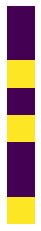

get


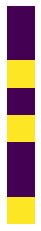

In [79]:
# Random patterns for testing content addresable memory
x1 = np.array([-1, -1, 1, -1, 1, -1, -1, 1]).reshape(-1,1)
x2 = np.array([-1, -1, -1, -1, -1, 1, -1, -1]).reshape(-1,1)
x3 = np.array([-1, 1, 1, -1, -1, 1, -1, 1]).reshape(-1,1)

patterns = np.vstack([x1.T, x2.T, x3.T])


hn = HopfieldNetwork()
hn.init_weights(patterns, self_connections=True)

print("weights are")
print(hn.weights)

rx1 = hn.recall(x1, if_sequential=False)
rx2 = hn.recall(x2, if_sequential=False)
rx3 = hn.recall(x3, if_sequential=False)

assert np.all(x1 == rx1), "x1 cannot be addressed"
assert np.all(x2 == rx2), "x2 cannot be addressed"
assert np.all(x3 == rx3), "x3 cannot be addressed"

print("Recalling x1")
plt.imshow(rx1)
plt.axis("off")
plt.show()

print("get")
plt.imshow(x1)
plt.axis("off")
plt.show()

All can be retrieved, content addressable memory works. x1, x2, and x3 will be attractors of the network.

## Convergence and attractors

Recalling distorted patterns. x1d has a one bit error, x2d and x3d have two bit errors.

xd1 converged to x1 after 2 iterations
xd1


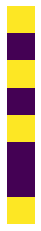

converged to


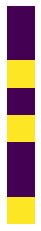

it should have converged to x1


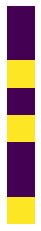

xd2 did not converge to x2
xd2


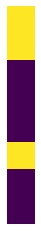

converged to


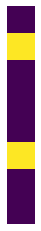

it should have converged to x2


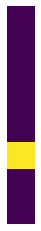

xd3 converged to x3 after 3 iterations
xd3


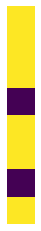

converged to


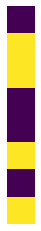

it should have converged to x3


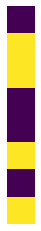

In [80]:
x1d = np.array([1, -1, 1, -1, 1, -1, -1, 1]).reshape(-1,1)
x2d = np.array([1, 1, -1, -1, -1, 1, -1, -1]).reshape(-1,1)
x3d = np.array([1, 1, 1, -1, 1, 1, -1, 1]).reshape(-1,1)

patternsd = np.vstack([x1d.T, x2d.T, x3d.T])

hn = HopfieldNetwork()
hn.init_weights(patterns, self_connections=True)

for idx, p, pd in zip(range(patterns.shape[0]), patterns, patternsd):
    pr, it, _ = hn.recall_until_convergence(pd, with_energy=False, if_sequential=False)
    if np.all(pr == p):
        print(f"xd{idx+1} converged to x{idx+1} after {it} iterations")
    else:
        print(f"xd{idx+1} did not converge to x{idx+1}")
    
    print(f"xd{idx+1}")
    plt.imshow(pd.reshape(-1,1))
    plt.axis("off")
    plt.show()
    
    print(f"converged to")
    plt.imshow(pr.reshape(-1,1))
    plt.axis("off")
    plt.show()
    
    
    print(f"it should have converged to x{idx+1}")
    plt.imshow(p.reshape(-1,1))
    plt.axis("off")
    plt.show()

With self_connections = False, only x1d converges to x1 in 2 iterations, the rest do not converge at all.
With self_connections = True, all converge - x1d to x1 in 2 iterations, x2d to a 1-bit corrupted (at index 1) version of x2, and x3d to x3 in 3 iterations.

Finding the number of attractors in the network.

In [81]:
attractors = hn.get_attractors(if_sequential=False)
print(attractors)
print(f"There are {attractors.shape[0]} attractors (each one is a row)")

for idx, pattern in enumerate(patterns):
    idx_attractor = hn.if_attractor(pattern, if_sequential=False)
    print(f"x{idx+1} is an attractor at index {idx_attractor}")

[[-1. -1. -1. -1. -1.  1. -1. -1.]
 [-1. -1. -1. -1.  1. -1. -1. -1.]
 [-1. -1.  1. -1. -1.  1. -1.  1.]
 [-1. -1.  1. -1.  1. -1. -1.  1.]
 [-1. -1.  1. -1.  1.  1. -1.  1.]
 [-1.  1. -1. -1. -1.  1. -1. -1.]
 [-1.  1.  1. -1. -1.  1. -1.  1.]
 [-1.  1.  1. -1.  1. -1. -1.  1.]
 [ 1. -1. -1.  1.  1. -1.  1. -1.]
 [ 1.  1. -1.  1. -1.  1.  1. -1.]
 [ 1.  1. -1.  1.  1. -1.  1. -1.]
 [ 1.  1. -1.  1.  1.  1.  1. -1.]
 [ 1.  1.  1.  1. -1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1. -1.  1.  1.]]
There are 14 attractors (each one is a row)
x1 is an attractor at index 3
x2 is an attractor at index 0
x3 is an attractor at index 6


When the starting pattern is made even more dissimilar to the stored ones (e.g. more than half is wrong), the distorted patterns do not converge to their correct attractor.

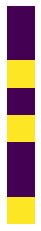

In [82]:
patterns_for_x1 = np.array([[-1, 1, -1, 1, -1, -1, -1, 1], # last 3 same as x1
                            [1, -1, 1, 1, -1, 1, 1, -1],# first 3 same
                            [1, 1, -1, 1, -1, 1, 1, -1]]) # only 1st same

plt.imshow(x1)
plt.axis("off")
plt.show()

all should converge to x1


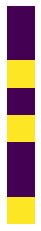

converged to x1: False


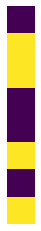

converged to x1: False


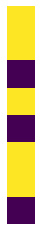

converged to x1: False


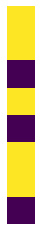

In [83]:
print("all should converge to x1")
plt.imshow(x1.reshape(-1,1))
plt.axis("off")
plt.show()

for pattern_for_x1 in patterns_for_x1:
    x1r, it, _ = hn.recall_until_convergence(pattern_for_x1, with_energy=False, if_sequential=False)
    print(f"converged to x1: {np.all(pattern_for_x1 == x1)}")
    plt.imshow(x1r.reshape(-1,1))
    plt.axis("off")
    plt.show()

## Sequential / Asynchronous Update

In [85]:
def read_pict_data(path_2_data):
    """ Read pict.dat data. 11 binary images of shape (32, 32). Last two are distorted 
    versions of previous ones.
    
    Parameters
    ----------
    path_2_data : str
        Path to data.
    
    Returns
    ----------
    numpy.ndarray
        Data as array of shape (11, 1024)
    """
    ndim = 1024
    return np.loadtxt(path_2_data, delimiter=",", dtype=int).reshape(-1, ndim)
    
path_2_data='pict.dat'
patterns_all = read_pict_data(path_2_data)

# Get first 3 images.
patterns = patterns_all[:3,:]
print(patterns.shape)

(3, 1024)


Check an example image.

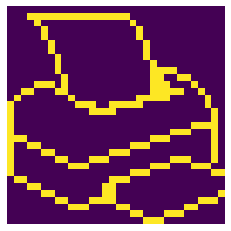

In [86]:
show_idx = 0
plt.imshow(patterns[show_idx].reshape(32,-1).T)
plt.axis("off")
plt.show()

Add teh first 3 images to the network and test if they are stable with synchronous update.

in 1 iterations this converged to


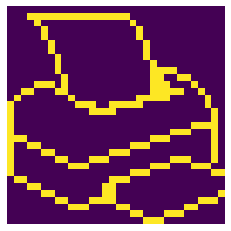

this


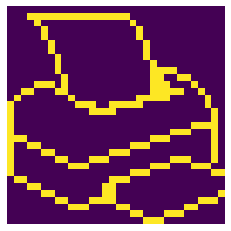

in 1 iterations this converged to


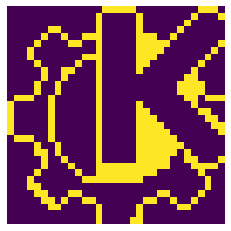

this


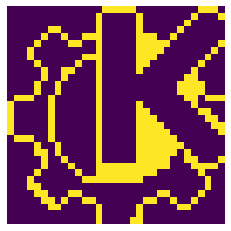

in 1 iterations this converged to


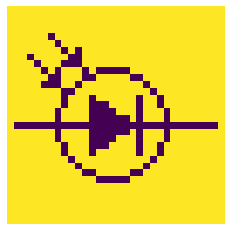

this


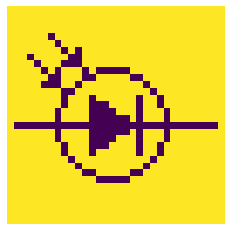

In [87]:
hn = HopfieldNetwork()
hn.init_weights(patterns, self_connections=False, norm=False)

for pattern in patterns:
    patternr, it, _ = hn.recall_until_convergence(pattern, with_energy=False, if_sequential=False, exit=100)
    print(f"in {it} iterations this converged to")
    plt.imshow(pattern.reshape(32,-1).T)
    plt.axis("off")
    plt.show()
    print(f"this")
    plt.imshow(patternr.reshape(32,-1).T)
    plt.axis("off")
    plt.show()

Image at index 9 is the distorted version of image at index 0.

p10 below


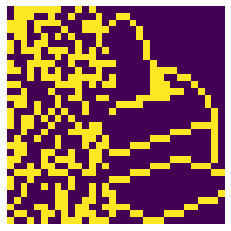

is a degraded version of p1 below


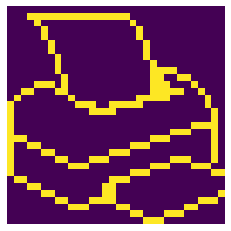

In [88]:
print("p10 below")
plt.imshow(patterns_all[9].reshape(32,-1).T)
plt.axis("off")
plt.show()

print("is a degraded version of p1 below")
plt.imshow(patterns_all[0].reshape(32,-1).T)
plt.axis("off")
plt.show()

Let's try to recall it with synchronous update.

in 2 iterations p10 converged to


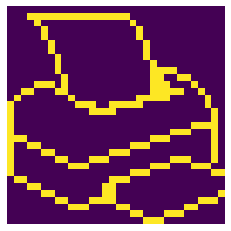

In [89]:
patternr, it, _ = hn.recall_until_convergence(patterns_all[9], 
                                              if_sequential=False, with_energy=False, exit=1000)
print(f"in {it} iterations p10 converged to")
plt.imshow(patternr.reshape(32,-1).T)
plt.axis("off")
plt.show()

p10 converges to stable point p1 in 2 iterations.

image at index 10 is a mixture of the images at indices 1 and 2

p11 below


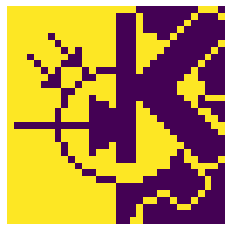

is a mixture of version of p2 and p3 below (in this order)


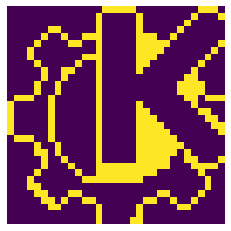

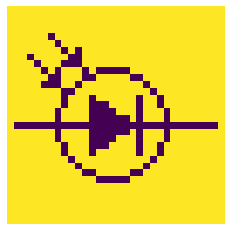

In [90]:
print("p11 below")
plt.imshow(patterns_all[10].reshape(32,-1).T)
plt.axis("off")
plt.show()

print("is a mixture of version of p2 and p3 below (in this order)")
plt.imshow(patterns_all[1].reshape(32,-1).T)
plt.axis("off")
plt.show()

plt.imshow(patterns_all[2].reshape(32,-1).T)
plt.axis("off")
plt.show()

Let's try to recall it with synchronous update.

in 3 iterations p11 converged to


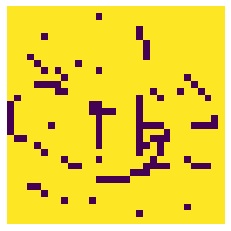

In [91]:
viz_recall_dict = {}
patternr, it, _ = hn.recall_until_convergence(patterns_all[10], if_sequential=False, with_energy=False,
                                           exit=10000, **viz_recall_dict)
print(f"in {it} iterations p11 converged to")
plt.imshow(patternr.reshape(32,-1).T)
plt.axis("off")
plt.show()

p11 converges in 2-3 iterations to a spurious stable point (neither p2 or p3)

However, p11 does converge to p3 when the asynchrnonous update rule is used.

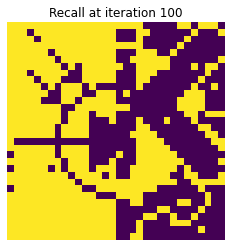

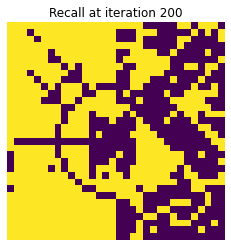

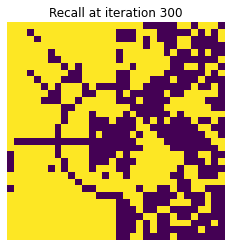

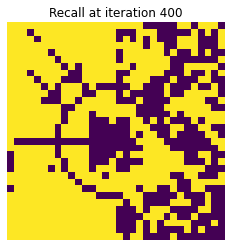

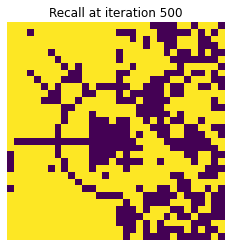

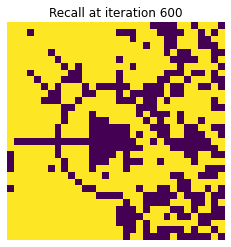

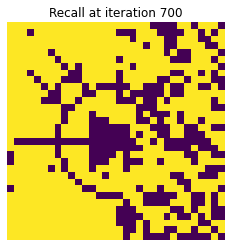

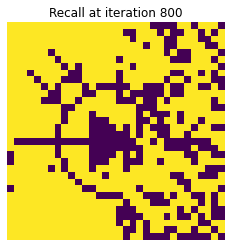

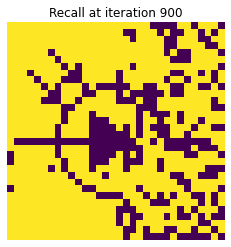

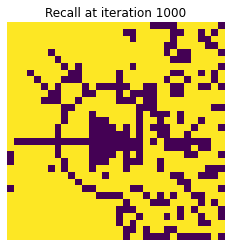

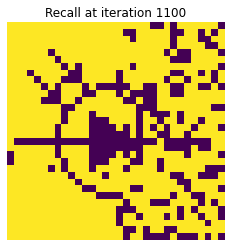

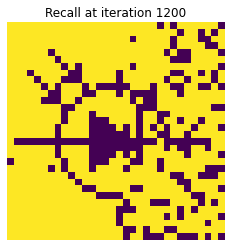

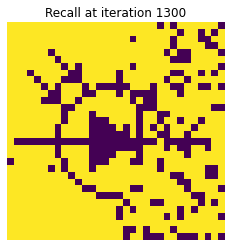

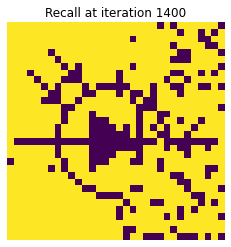

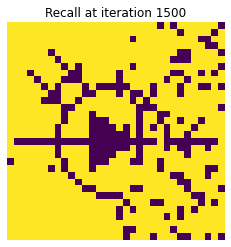

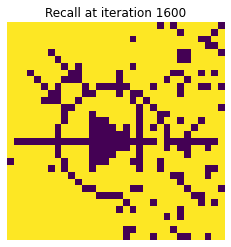

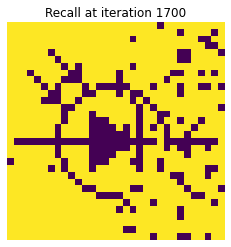

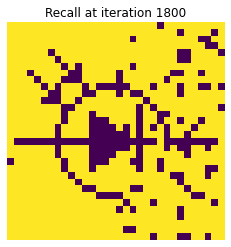

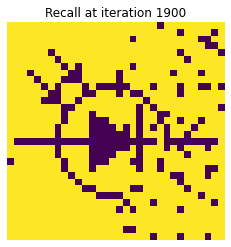

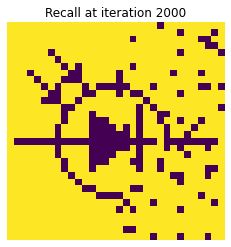

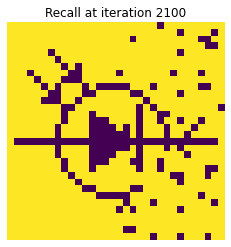

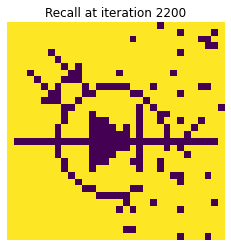

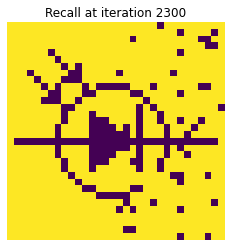

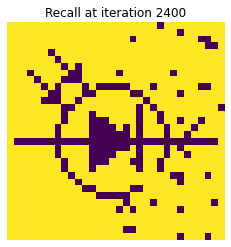

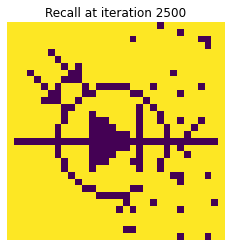

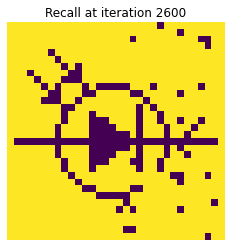

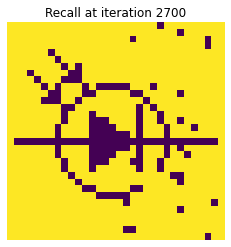

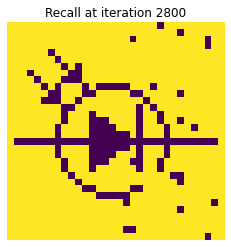

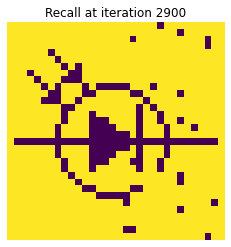

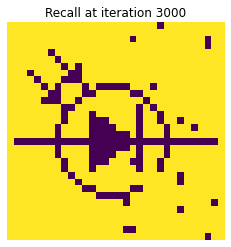

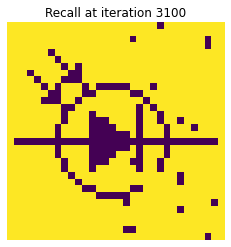

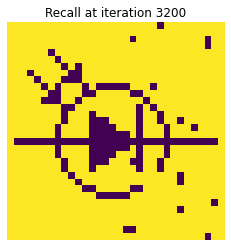

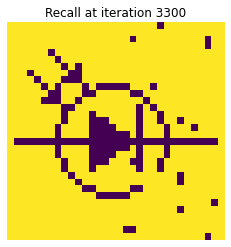

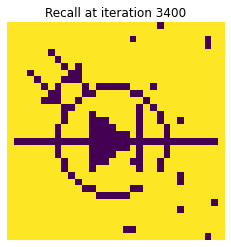

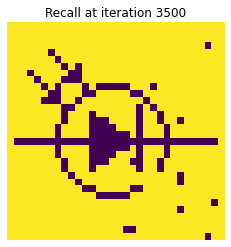

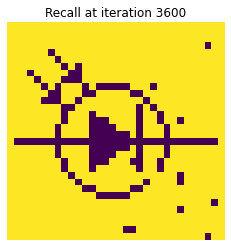

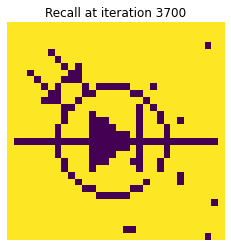

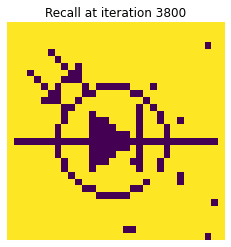

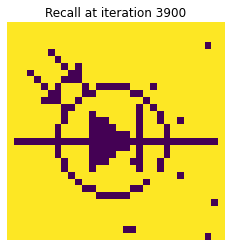

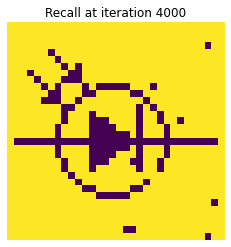

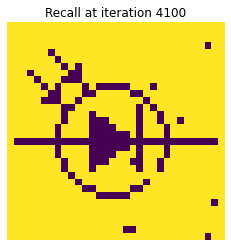

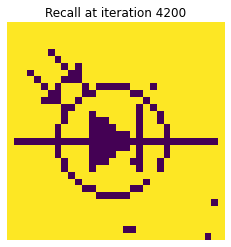

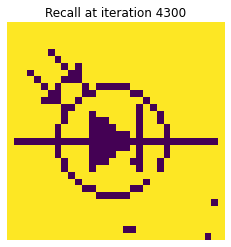

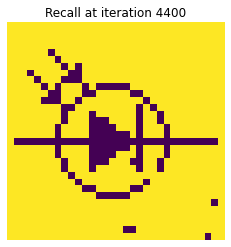

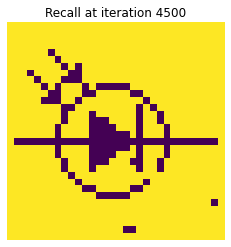

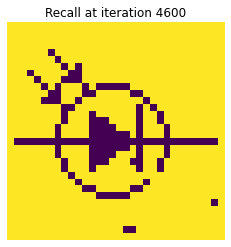

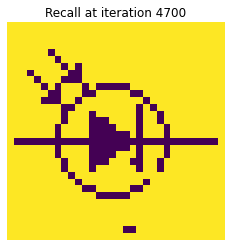

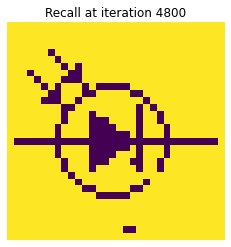

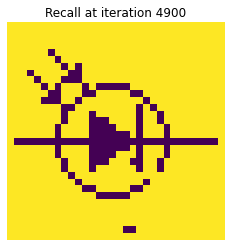

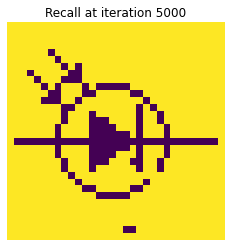

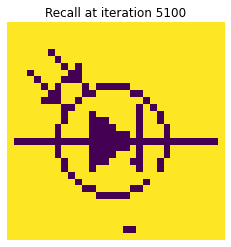

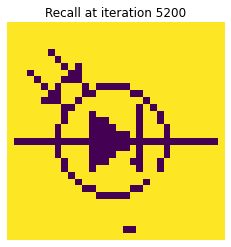

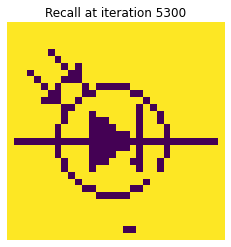

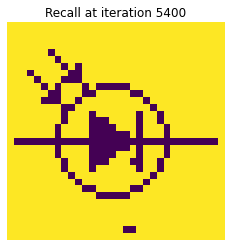

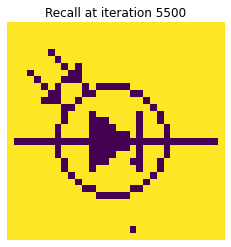

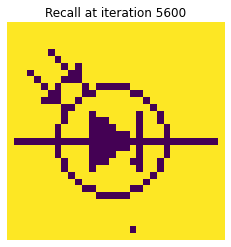

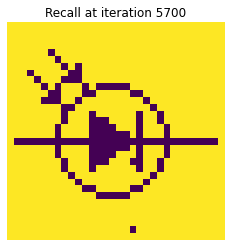

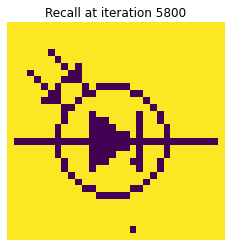

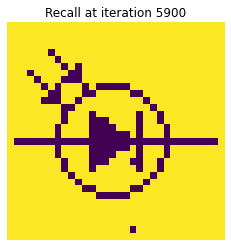

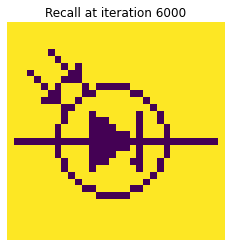

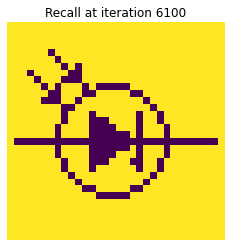

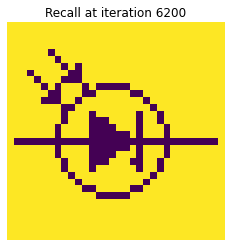

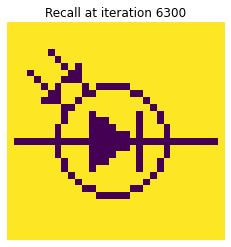

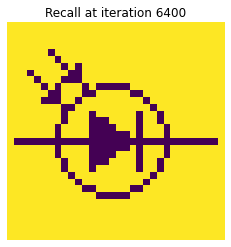

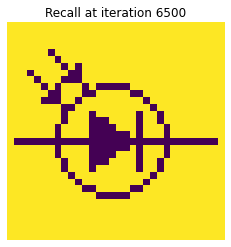

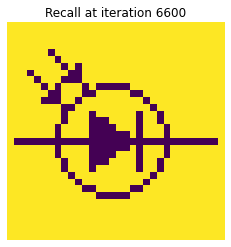

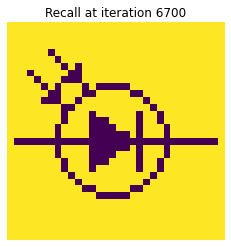

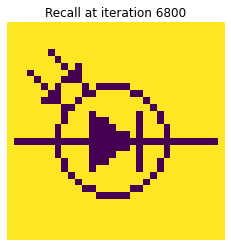

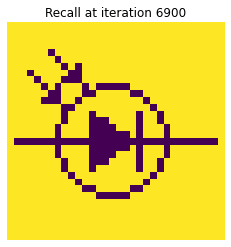

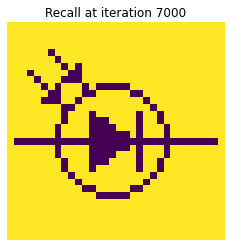

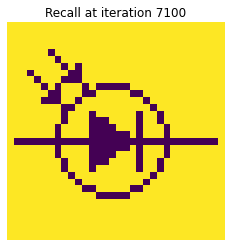

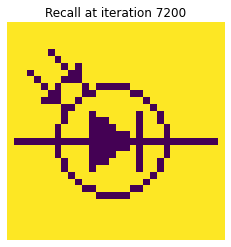

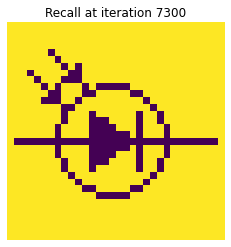

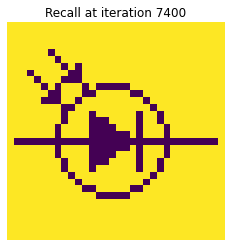

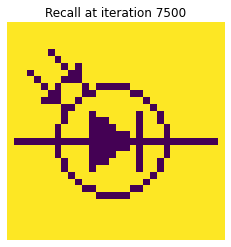

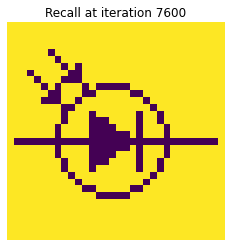

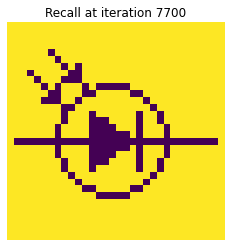

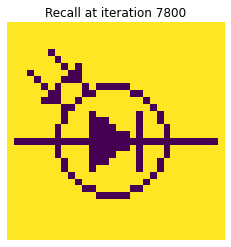

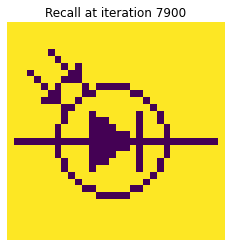

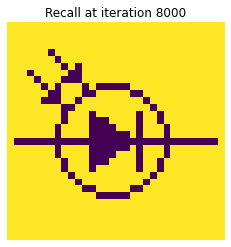

in 8000 iterations p11 converged to


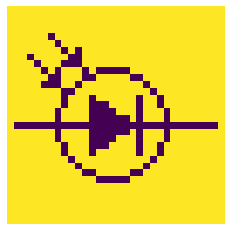

In [93]:
viz_recall_dict = {"i": 100, "shape": (32, 32)}
patternr, it, _ = hn.recall_until_convergence(patterns_all[10], if_sequential=True, with_energy=False,
                                           exit=8000, **viz_recall_dict)
print(f"in {it} iterations p11 converged to")
plt.imshow(patternr.reshape(32,-1).T)
plt.axis("off")
plt.show()

After around 8k iterations, we p11 converges to the stable point p3 with sequential update.

## Energy in Hopfield Networks

The energies of the image data points in the network that stores the first 3 images are

In [94]:
for idx, pattern in enumerate(patterns_all):
    print(f"x{idx+1} e: {hn.energy(pattern.flatten())}")

x1 e: -1470864.0
x2 e: -1395344.0
x3 e: -1494272.0
x4 e: -734700.0
x5 e: -535440.0
x6 e: -696624.0
x7 e: -699116.0
x8 e: -172592.0
x9 e: -270860.0
x10 e: -422892.0
x11 e: -174592.0


The distorted p10 and the mixed p11 have greater energy, which it makes sense as they are not attractors - p10 is a degraded version of p1, and p11 is a mix between p2 and p3.

Asynchrnously recall p11 (mix) and observe the energy vs. iteration. The energy is minimized at the recalled pattern approaches the attractor - a local minimum in the energy landscape of the network.

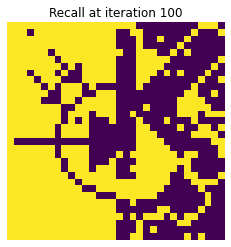

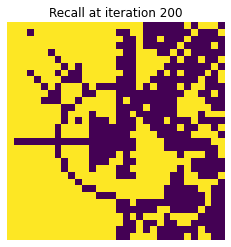

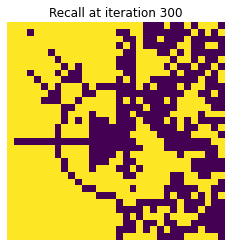

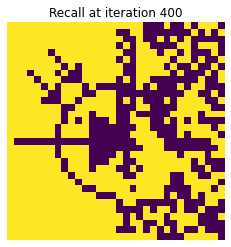

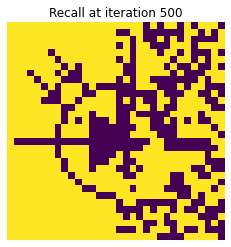

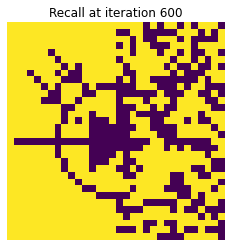

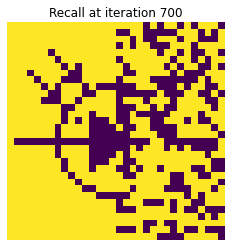

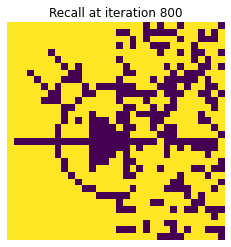

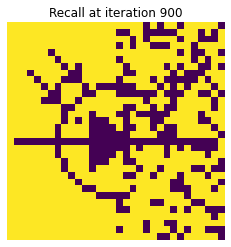

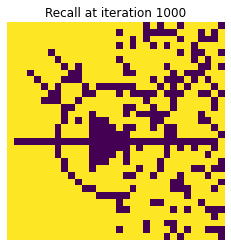

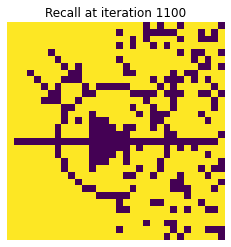

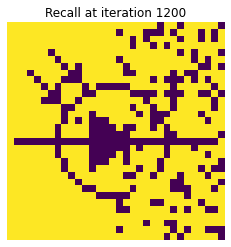

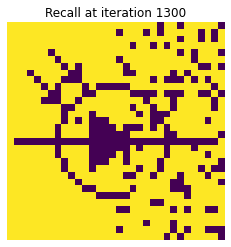

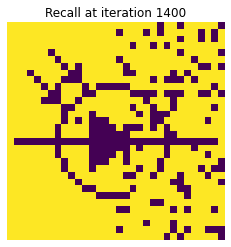

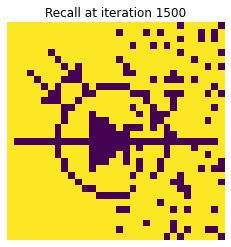

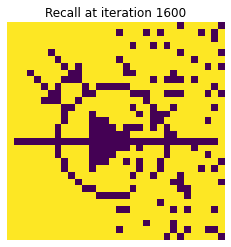

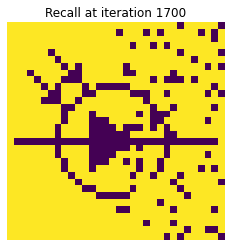

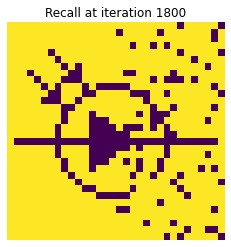

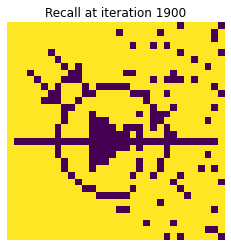

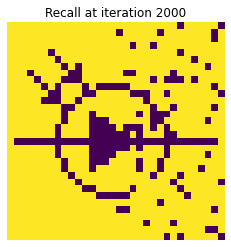

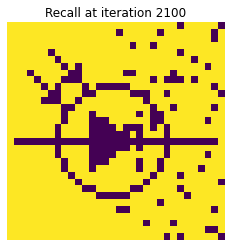

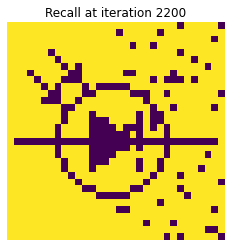

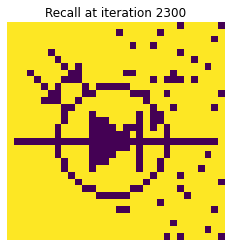

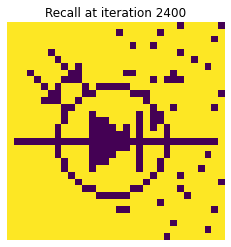

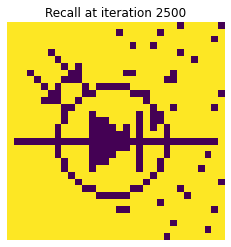

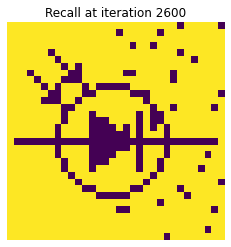

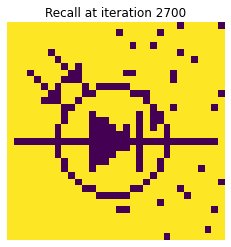

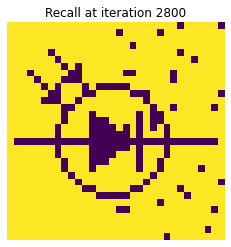

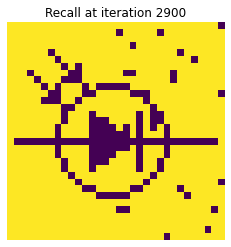

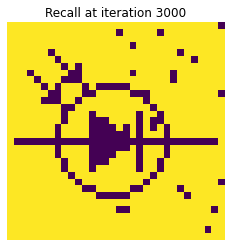

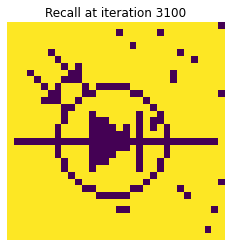

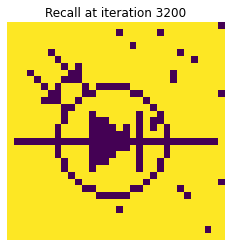

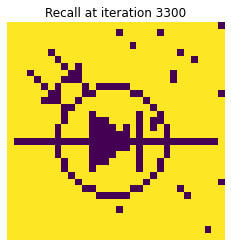

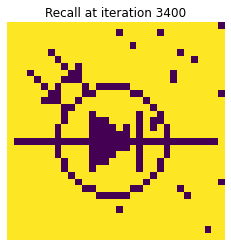

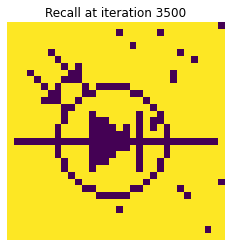

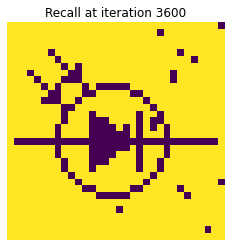

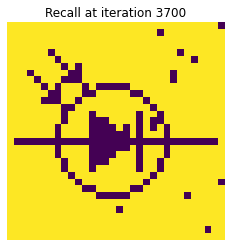

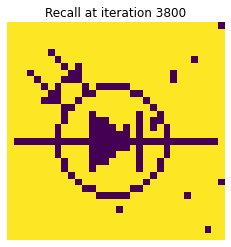

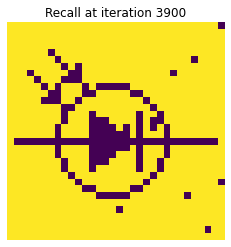

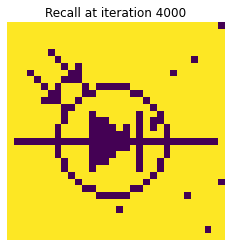

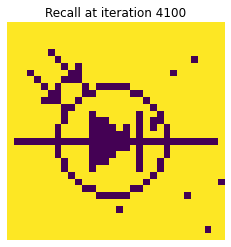

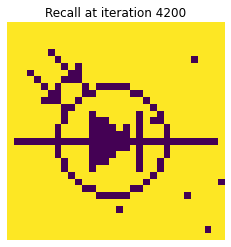

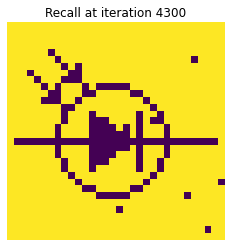

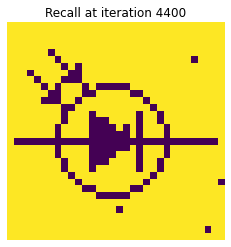

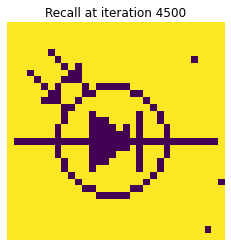

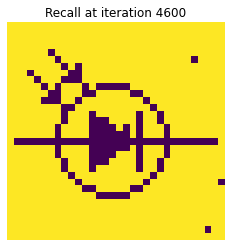

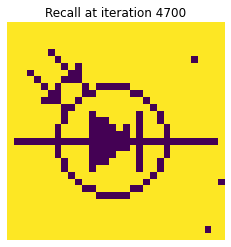

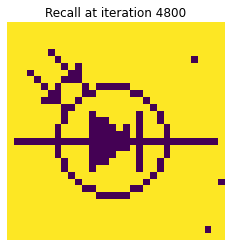

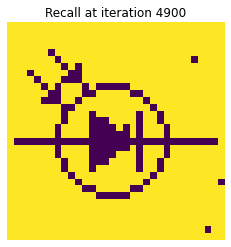

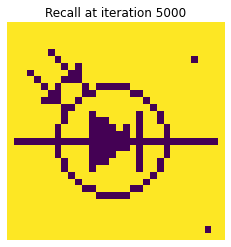

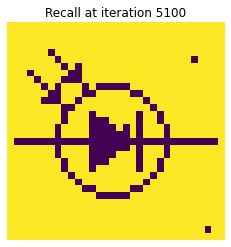

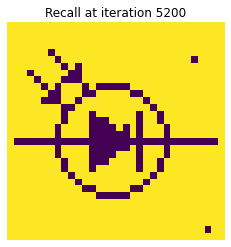

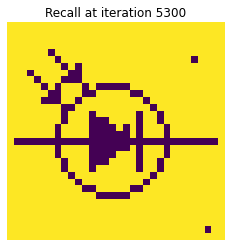

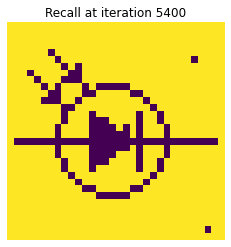

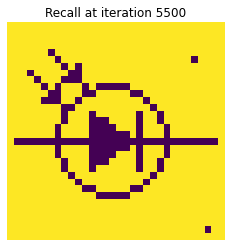

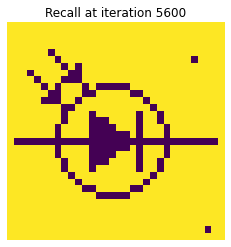

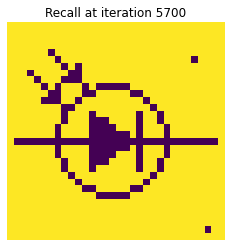

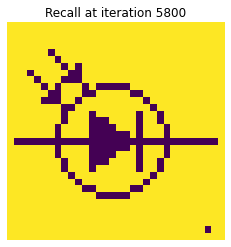

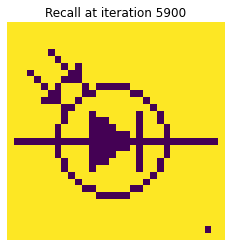

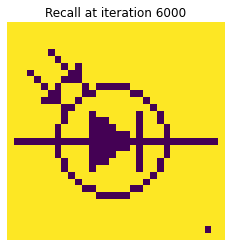

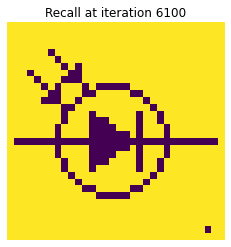

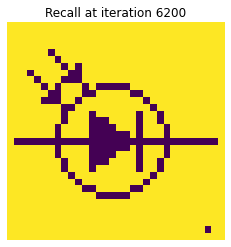

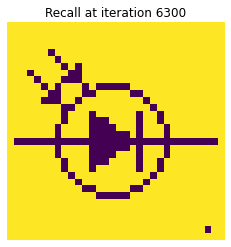

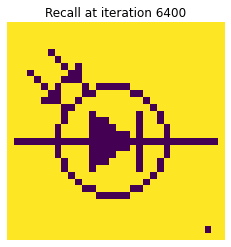

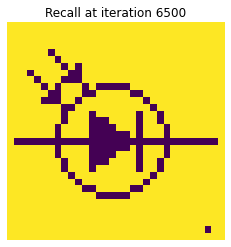

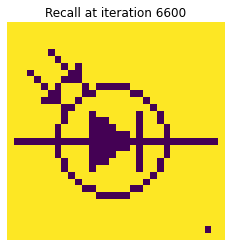

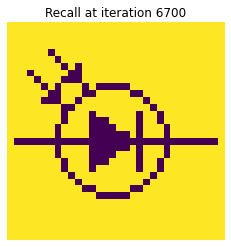

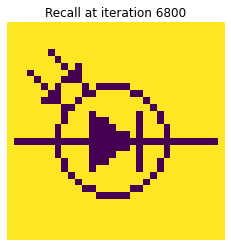

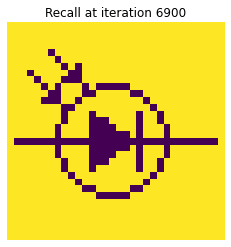

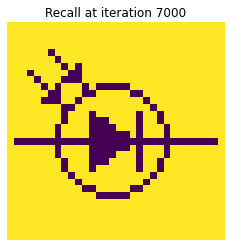

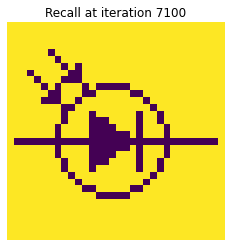

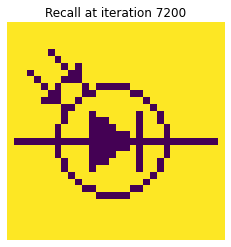

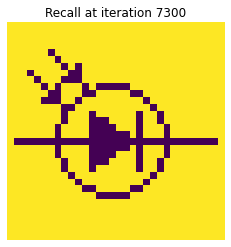

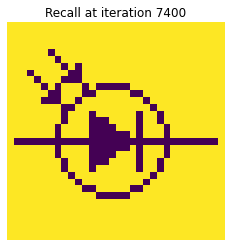

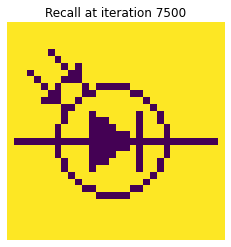

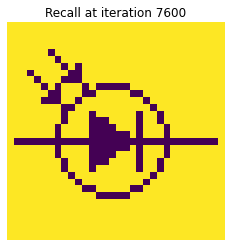

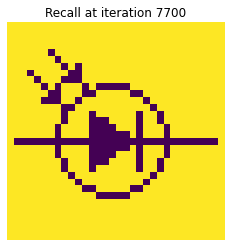

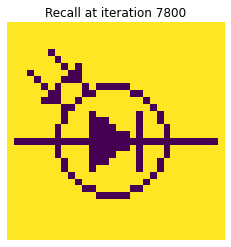

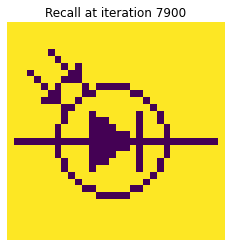

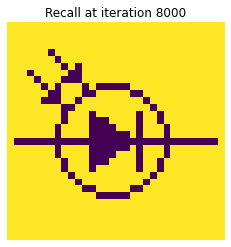

in 8000 iterations p11 converged to


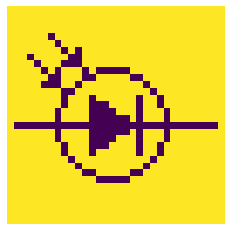

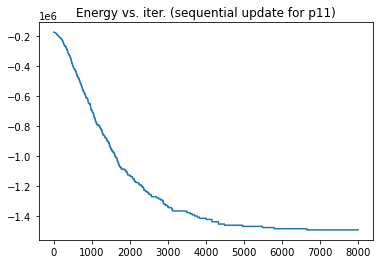

In [95]:
viz_recall_dict = {"i": 100, "shape": (32, 32)}
patternr, it, energies = hn.recall_until_convergence(patterns_all[10], if_sequential=True, with_energy=True,
                                           exit=8000, **viz_recall_dict)
print(f"in {it} iterations p11 converged to")
plt.imshow(patternr.reshape(32,-1).T)
plt.axis("off")
plt.show()

plt.plot(energies)
plt.title("Energy vs. iter. (sequential update for p11)")
plt.show()

Setting (forcing) the weight matrix of the network to be drawn from a normal distribution (i.e.: not symmetric, should fail to recall), and iterating an arbitrary starting state (e.g.: p2) reults in the following: the recalled pattern is not drawn to any attractor, and the energy is fluctuating, even reaches postitive values - the recall is also Gaussian noise.

the weights are forced to by asymmetric Gaussian
[[ 1.29176055 -0.30633504  0.58531489 ... -0.31098309  0.26876823
  -0.12698668]
 [ 0.55191967 -0.40984186 -0.76736109 ... -1.4629574   0.68926236
   0.65155715]
 [-2.15237958 -2.08672238  1.05146811 ... -1.50869914  1.19311557
  -0.22260611]
 ...
 [-2.00009908 -0.79720179 -0.21510214 ...  0.651326   -2.05382958
  -1.06294625]
 [ 2.14786803  0.61739712  0.11332657 ... -0.19709068  0.72792914
   0.89102156]
 [ 0.24307498  1.12643137 -1.1315491  ... -0.14070621 -0.74138892
  -1.03824365]]


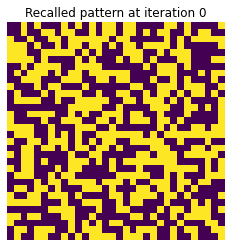

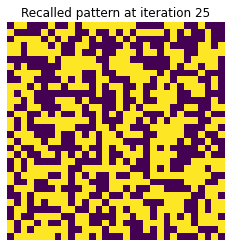

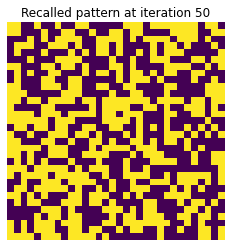

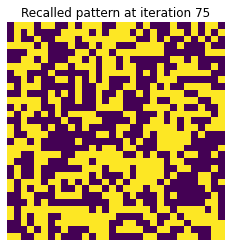

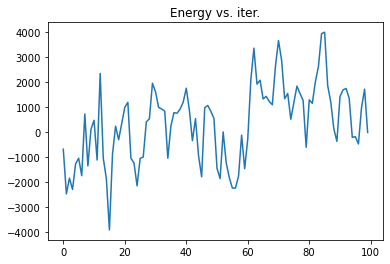

In [99]:
rule_dict = {"rule": "gaussian", "loc": 0.0, "scale": 1.0}
#rule_dict = {"rule": "symmetrize"}
hn.set_weights(**rule_dict)
assert not np.all(hn.weights == hn.weights.T)

print("the weights are forced to by asymmetric Gaussian")
print(hn.weights)

es = []
p_random = patterns_all[1]
for i in range(100):
    p_random = hn.recall(p_random, if_sequential=False)
    es.append(hn.energy(p_random.flatten()))
    if i % 25 == 0:
        plt.imshow(p_random.reshape(32,32).T)
        plt.title(f"Recalled pattern at iteration {i}")
        plt.axis("off")
        plt.show()

plt.plot(es)
plt.title("Energy vs. iter.")
plt.show()

Now, the weight matrix is forced to be symmetric (e.g. by setting w=0.5*(w+w')), but from the previous Gaussain. As a result, the weigts do not store the first 3 patterns.

Iterating a pattern (e.g.: p2), the recalled pattern is now drawn to an attractor since the weights are symmetric. But, this attractor is a spurious attractor since the weights do not store the desired 3 patterns. The energy gets stuck in local minimum (not global).

the symmetric weigths are
[[ 1.29176055  0.12279231 -0.78353235 ... -1.15554108  1.20831813
   0.05804415]
 [ 0.12279231 -0.40984186 -1.42704174 ... -1.13007959  0.65332974
   0.88899426]
 [-0.78353235 -1.42704174  1.05146811 ... -0.86190064  0.65322107
  -0.6770776 ]
 ...
 [-1.15554108 -1.13007959 -0.86190064 ...  0.651326   -1.12546013
  -0.60182623]
 [ 1.20831813  0.65332974  0.65322107 ... -1.12546013  0.72792914
   0.07481632]
 [ 0.05804415  0.88899426 -0.6770776  ... -0.60182623  0.07481632
  -1.03824365]]


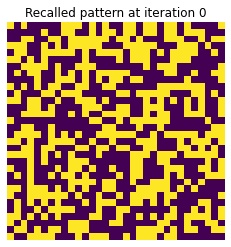

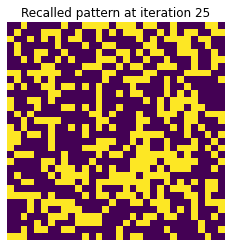

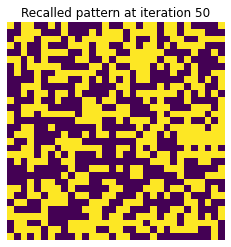

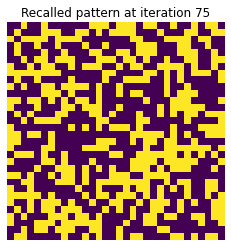

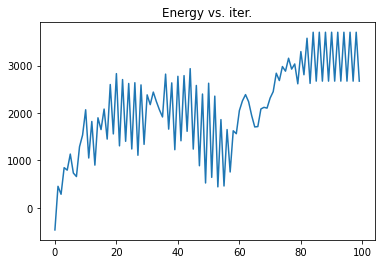

In [102]:
# Symmetrize prev Gaussian.
rule_dict = {"rule": "symmetrize"}
hn.set_weights(**rule_dict)
assert np.all(hn.weights == hn.weights.T)
print("the symmetric weigths are")
print(hn.weights)

es = []
p_random = patterns_all[1]
for i in range(100):
    p_random = hn.recall(p_random, if_sequential=False)
    es.append(hn.energy(p_random.flatten()))
    if i % 25 == 0:
        plt.imshow(p_random.reshape(32,32).T)
        plt.title(f"Recalled pattern at iteration {i}")
        plt.axis("off")
        plt.show()

plt.plot(es)
plt.title("Energy vs. iter.")
plt.show()

## 3.4 Distortion Resistance

In [31]:
patterns_all = read_pict_data(path_2_data)
patterns = patterns_all[:3,:]
print(patterns.shape)

hn = HopfieldNetwork()
hn.init_weights(patterns, self_connections=True, norm=False)
hn.weights

(3, 1024)


array([[3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       ...,
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.]])

In [32]:
def add_noise_via_flip(pattern, ratio, seed=100):
    assert pattern.ndim == 1
    assert 0 <= ratio <= 1.0
    indices = np.arange(pattern.size)
    n = int(ratio * pattern.size)
    np.random.seed(seed)
    indices_flip = np.random.choice(indices, n, replace=False)
    pattern_noisy = pattern.copy()
    pattern_noisy[indices_flip] = - pattern[indices_flip]
    return pattern_noisy

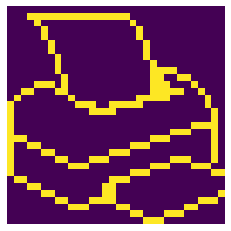

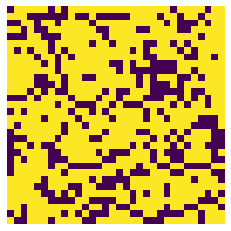

In [33]:
idx = 0
ratio = 0.8

plt.imshow(patterns[idx].reshape(32,-1).T)
plt.axis("off")
plt.show()

pattern_noisy = add_noise_via_flip(patterns[idx], ratio)

plt.imshow(pattern_noisy.reshape(32,-1).T)
plt.axis("off")
plt.show()

in 2 iterations p1 with 80.0% noise


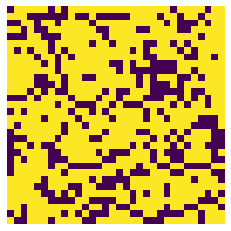

converged to this


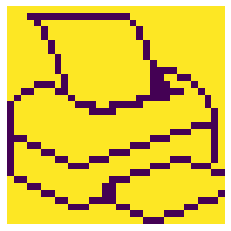

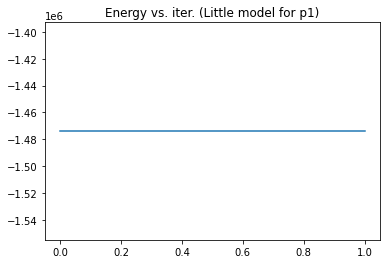

in 2 iterations p2 with 80.0% noise


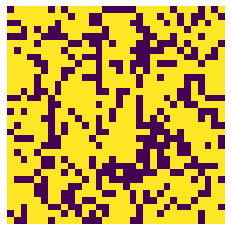

converged to this


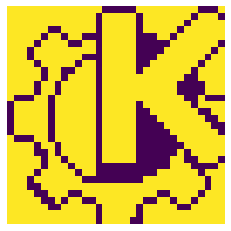

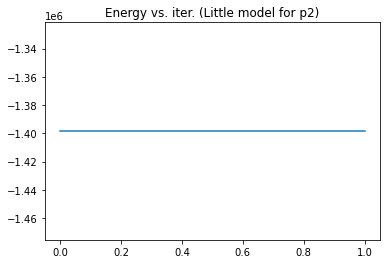

in 2 iterations p3 with 80.0% noise


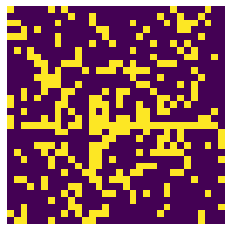

converged to this


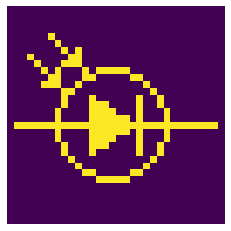

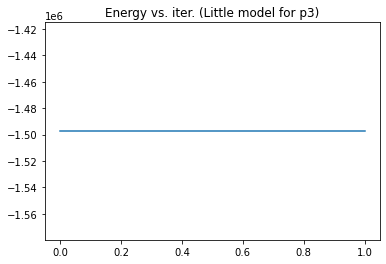

In [34]:
ratio = 0.1
ratio = 0.4
ratio = 0.5
ratio = 0.6
ratio = 0.8

for idx, pattern in enumerate(patterns):
    pattern_noisy = add_noise_via_flip(pattern, ratio)
    
    viz_recall_dict = {"i": 100, "shape": (32, 32)}
    patternr, it, energies = hn.recall_until_convergence(pattern_noisy, if_sequential=False, with_energy=True,
                                               exit=1000, **viz_recall_dict)
    print(f"in {it} iterations p{idx+1} with {ratio*100}% noise")
    plt.imshow(pattern_noisy.reshape(32,-1).T)
    plt.axis("off")
    plt.show()
    
    print("converged to this")
    
    plt.imshow(patternr.reshape(32,-1).T)
    plt.axis("off")
    plt.show()

    plt.plot(energies)
    plt.title(f"Energy vs. iter. (Little model for p{idx+1})")
    plt.show()

Q: How much noise can be removed?

Answer: Up to 50 % of noise (randomly flip this many pixels) can be removed - noisy p1, p2, and p3 all converge to their own attractors, i.e.: themselves. 
At 50 %, noisy p1, p2, and p3 converges to p2, p1, and p1, respectively - incorrect attractors.
At 60%, noisy p1 and p2 converge to the inverse of their attractors, and noisy p3 converges to a spurious attractor.
Beyond around 70 %, they all converge to the inverse of their respective, correct attractors .

## 3.5 Capacity

Now add more and more memories to the network to see where the limit is. Start by adding p4 into the weight matrix and check if moderately distorted patters can still be recognized. Then continue by adding others such as p5, p6, and p7 in some order and checking the performance after each addition.

In [35]:
patterns_all = read_pict_data(path_2_data)
n_patterns = 4
patterns = patterns_all[:n_patterns,:]
print(patterns.shape)

(4, 1024)


Try batch mode (Little model)

in 2 iterations this converged to


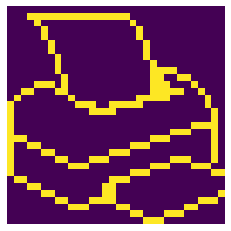

this


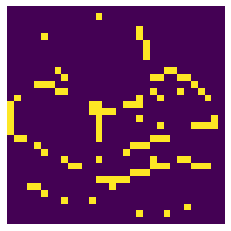

in 3 iterations this converged to


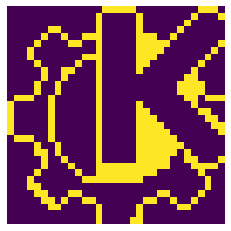

this


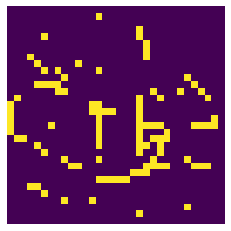

in 2 iterations this converged to


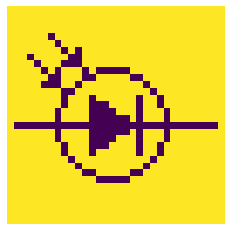

this


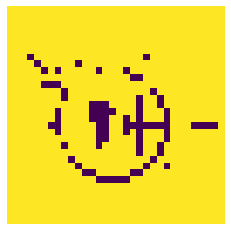

in 3 iterations this converged to


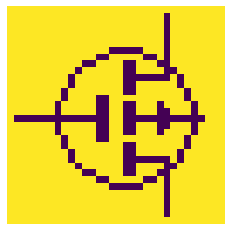

this


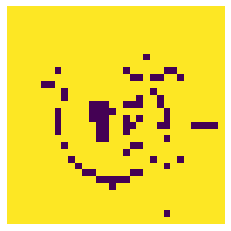

In [36]:
if_sequential = False
hn = HopfieldNetwork()
hn.init_weights(patterns, self_connections=True, norm=False)

for pattern in patterns:
    patternr, it, _ = hn.recall_until_convergence(pattern, with_energy=False, 
                                                     if_sequential=if_sequential, 
                                                     exit=10000)
    print(f"in {it} iterations this converged to")
    plt.imshow(pattern.reshape(32,-1).T)
    plt.axis("off")
    plt.show()
    print(f"this")
    plt.imshow(patternr.reshape(32,-1).T)
    plt.axis("off")
    plt.show()

Try sequential mode.

in 10000 iterations this converged to


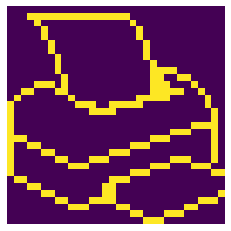

this


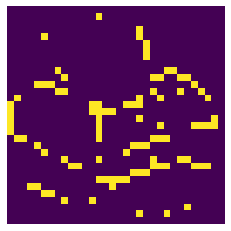

in 10000 iterations this converged to


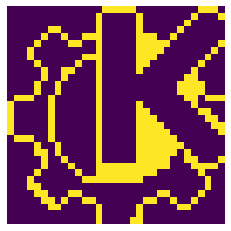

this


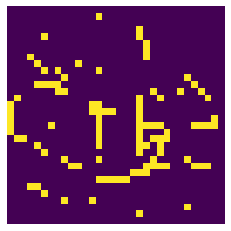

in 10000 iterations this converged to


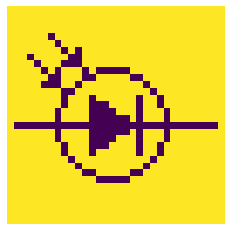

this


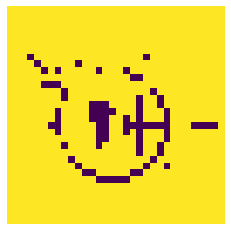

in 10000 iterations this converged to


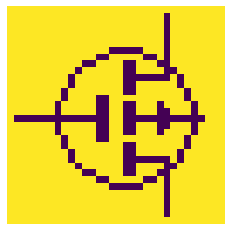

this


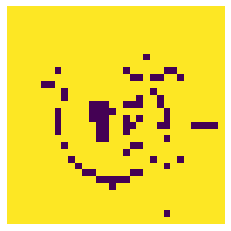

In [37]:
if_sequential = True
hn = HopfieldNetwork()
hn.init_weights(patterns, self_connections=True, norm=False)

for pattern in patterns:
    patternr, it, _ = hn.recall_until_convergence(pattern, with_energy=False, 
                                                     if_sequential=if_sequential, 
                                                     exit=10000)
    print(f"in {it} iterations this converged to")
    plt.imshow(pattern.reshape(32,-1).T)
    plt.axis("off")
    plt.show()
    print(f"this")
    plt.imshow(patternr.reshape(32,-1).T)
    plt.axis("off")
    plt.show()

Q: How many patterns could safely be stored? Was the drop in performance gradual or abrupt?

Answer: 3 patterns could be stored. Adding p4 and beyond worsens the network, and the patterns are not stable anymore.

Try to repeat this with learning a few random patterns instead of the pictures and see if you can store more.


Create 300 random patterns and train a 100-unit (or larger) network with them. After each new pattern has been added to the weight matrix, calculate how many of the earlier patterns remain stable (a single iteration does not cause them to change) and plot it.

In [38]:
def get_random_patterns(n, ndim, bias=0):
    patterns = np.random.normal(loc=0, scale=1, size=(n, ndim)) + bias
    mask = patterns < 0
    patterns[mask] = -1.0
    patterns[np.invert(mask)] = 1.0
    return patterns

In [39]:
patterns_random = get_random_patterns(n=10, ndim=100)
patterns_random.shape

(10, 100)

n_pattern=1, accuracy=1.0
n_pattern=2, accuracy=1.0
n_pattern=3, accuracy=1.0
n_pattern=4, accuracy=1.0
n_pattern=5, accuracy=1.0
n_pattern=6, accuracy=1.0
n_pattern=7, accuracy=1.0
n_pattern=8, accuracy=1.0
n_pattern=9, accuracy=1.0
n_pattern=10, accuracy=1.0
n_pattern=11, accuracy=1.0
n_pattern=12, accuracy=1.0
n_pattern=13, accuracy=1.0
n_pattern=14, accuracy=0.7857142857142857
n_pattern=15, accuracy=1.0
n_pattern=16, accuracy=1.0
n_pattern=17, accuracy=0.8823529411764706
n_pattern=18, accuracy=0.8888888888888888
n_pattern=19, accuracy=0.8421052631578947
n_pattern=20, accuracy=0.8
n_pattern=21, accuracy=0.6666666666666666
n_pattern=22, accuracy=0.9545454545454546
n_pattern=23, accuracy=0.6086956521739131
n_pattern=24, accuracy=0.7083333333333334
n_pattern=25, accuracy=0.48
n_pattern=26, accuracy=0.5
n_pattern=27, accuracy=0.5185185185185185
n_pattern=28, accuracy=0.6428571428571429
n_pattern=29, accuracy=0.5517241379310345
n_pattern=30, accuracy=0.4666666666666667
n_pattern=31, accu

n_pattern=205, accuracy=0.23414634146341465
n_pattern=206, accuracy=0.15048543689320387
n_pattern=207, accuracy=0.1642512077294686
n_pattern=208, accuracy=0.14903846153846154
n_pattern=209, accuracy=0.14354066985645933
n_pattern=210, accuracy=0.21904761904761905
n_pattern=211, accuracy=0.17535545023696683
n_pattern=212, accuracy=0.18867924528301888
n_pattern=213, accuracy=0.19718309859154928
n_pattern=214, accuracy=0.21962616822429906
n_pattern=215, accuracy=0.25116279069767444
n_pattern=216, accuracy=0.12037037037037036
n_pattern=217, accuracy=0.28110599078341014
n_pattern=218, accuracy=0.1559633027522936
n_pattern=219, accuracy=0.1735159817351598
n_pattern=220, accuracy=0.2
n_pattern=221, accuracy=0.19457013574660634
n_pattern=222, accuracy=0.2072072072072072
n_pattern=223, accuracy=0.16143497757847533
n_pattern=224, accuracy=0.21428571428571427
n_pattern=225, accuracy=0.2222222222222222
n_pattern=226, accuracy=0.19911504424778761
n_pattern=227, accuracy=0.2026431718061674
n_pattern=

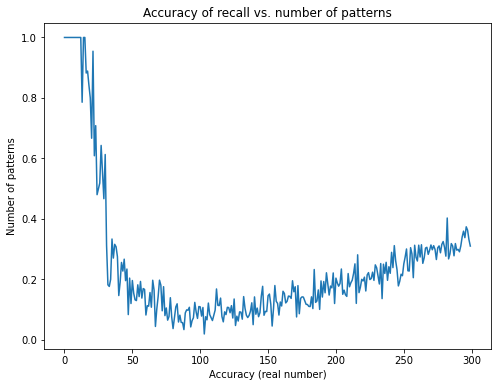

In [40]:
n_patterns = 300
ndim = 100
ns_patterns = np.arange(1, n_patterns+1)
accuracies_all = []

for n_pattern in ns_patterns:
    
    patterns_random = get_random_patterns(n=n_pattern, ndim=ndim)
    hn = HopfieldNetwork()
    hn.init_weights(patterns_random, self_connections=True, norm=False)
    accuracies = []
    
    for pattern in patterns_random:
        
        patternr, it, energies = hn.recall_until_convergence(pattern, with_energy=False, if_sequential=False, 
                                                  exit=10000)
        accuracies.append(np.all(pattern == patternr))
    
    accuracy = np.sum(np.array(accuracies)) / patterns_random.shape[0]
    accuracies_all.append(accuracy)
    
    print(f"n_pattern={n_pattern}, accuracy={accuracy}")

fig = plt.figure(figsize=(8,6))
plt.plot(accuracies_all)
plt.title("Accuracy of recall vs. number of patterns")
plt.xlabel("Accuracy (real number)")
plt.ylabel("Number of patterns")
plt.show()

Q: What happens with the number of stable patterns as more are learned?

Answer: ??

Q: It has been shown that the capacity of a Hopfield network is around 0.138N. How do you explain the difference between random patterns and the pictures?

Answer: ??

In [41]:
n_patterns = 100
ndim = 100
ns_patterns = np.arange(1, n_patterns+1)

accuracies_per_noise_ratio = {}

noise_ratios = np.arange(0,6) / 10

for noise_ratio in noise_ratios:
    accuracies_all = []
    for n_pattern in ns_patterns:

        patterns_random = get_random_patterns(n=n_pattern, ndim=ndim)
        hn = HopfieldNetwork()
        hn.init_weights(patterns_random, self_connections=True, norm=False)
        accuracies = []
        for pattern in patterns_random:
            pattern_noisy = add_noise_via_flip(pattern, noise_ratio)
            patternr, it, energies = hn.recall_until_convergence(pattern_noisy, 
                                                                 with_energy=False, if_sequential=False, 
                                                                 exit=10000)

            accuracies.append(np.all(pattern == patternr))

        accuracy = np.sum(np.array(accuracies)) / patterns_random.shape[0]
        accuracies_all.append(accuracy)

        print(f"noise_ratio={noise_ratio}, n_pattern={n_pattern}, accuracy={accuracy}")
    
    accuracies_per_noise_ratio[str(noise_ratio)] = accuracies_all

noise_ratio=0.0, n_pattern=1, accuracy=1.0
noise_ratio=0.0, n_pattern=2, accuracy=1.0
noise_ratio=0.0, n_pattern=3, accuracy=1.0
noise_ratio=0.0, n_pattern=4, accuracy=1.0
noise_ratio=0.0, n_pattern=5, accuracy=1.0
noise_ratio=0.0, n_pattern=6, accuracy=1.0
noise_ratio=0.0, n_pattern=7, accuracy=1.0
noise_ratio=0.0, n_pattern=8, accuracy=1.0
noise_ratio=0.0, n_pattern=9, accuracy=1.0
noise_ratio=0.0, n_pattern=10, accuracy=0.9
noise_ratio=0.0, n_pattern=11, accuracy=0.9090909090909091
noise_ratio=0.0, n_pattern=12, accuracy=1.0
noise_ratio=0.0, n_pattern=13, accuracy=0.9230769230769231
noise_ratio=0.0, n_pattern=14, accuracy=0.9285714285714286
noise_ratio=0.0, n_pattern=15, accuracy=0.8
noise_ratio=0.0, n_pattern=16, accuracy=0.875
noise_ratio=0.0, n_pattern=17, accuracy=0.9411764705882353
noise_ratio=0.0, n_pattern=18, accuracy=0.9444444444444444
noise_ratio=0.0, n_pattern=19, accuracy=0.7894736842105263
noise_ratio=0.0, n_pattern=20, accuracy=0.75
noise_ratio=0.0, n_pattern=21, accur

noise_ratio=0.1, n_pattern=72, accuracy=0.0
noise_ratio=0.1, n_pattern=73, accuracy=0.0
noise_ratio=0.1, n_pattern=74, accuracy=0.0
noise_ratio=0.1, n_pattern=75, accuracy=0.0
noise_ratio=0.1, n_pattern=76, accuracy=0.0
noise_ratio=0.1, n_pattern=77, accuracy=0.0
noise_ratio=0.1, n_pattern=78, accuracy=0.0
noise_ratio=0.1, n_pattern=79, accuracy=0.0
noise_ratio=0.1, n_pattern=80, accuracy=0.0
noise_ratio=0.1, n_pattern=81, accuracy=0.0
noise_ratio=0.1, n_pattern=82, accuracy=0.0
noise_ratio=0.1, n_pattern=83, accuracy=0.0
noise_ratio=0.1, n_pattern=84, accuracy=0.0
noise_ratio=0.1, n_pattern=85, accuracy=0.0
noise_ratio=0.1, n_pattern=86, accuracy=0.0
noise_ratio=0.1, n_pattern=87, accuracy=0.0
noise_ratio=0.1, n_pattern=88, accuracy=0.0
noise_ratio=0.1, n_pattern=89, accuracy=0.0
noise_ratio=0.1, n_pattern=90, accuracy=0.0
noise_ratio=0.1, n_pattern=91, accuracy=0.0
noise_ratio=0.1, n_pattern=92, accuracy=0.0
noise_ratio=0.1, n_pattern=93, accuracy=0.0
noise_ratio=0.1, n_pattern=94, a

noise_ratio=0.3, n_pattern=52, accuracy=0.0
noise_ratio=0.3, n_pattern=53, accuracy=0.0
noise_ratio=0.3, n_pattern=54, accuracy=0.0
noise_ratio=0.3, n_pattern=55, accuracy=0.0
noise_ratio=0.3, n_pattern=56, accuracy=0.0
noise_ratio=0.3, n_pattern=57, accuracy=0.0
noise_ratio=0.3, n_pattern=58, accuracy=0.0
noise_ratio=0.3, n_pattern=59, accuracy=0.0
noise_ratio=0.3, n_pattern=60, accuracy=0.0
noise_ratio=0.3, n_pattern=61, accuracy=0.0
noise_ratio=0.3, n_pattern=62, accuracy=0.0
noise_ratio=0.3, n_pattern=63, accuracy=0.0
noise_ratio=0.3, n_pattern=64, accuracy=0.0
noise_ratio=0.3, n_pattern=65, accuracy=0.0
noise_ratio=0.3, n_pattern=66, accuracy=0.0
noise_ratio=0.3, n_pattern=67, accuracy=0.0
noise_ratio=0.3, n_pattern=68, accuracy=0.0
noise_ratio=0.3, n_pattern=69, accuracy=0.0
noise_ratio=0.3, n_pattern=70, accuracy=0.0
noise_ratio=0.3, n_pattern=71, accuracy=0.0
noise_ratio=0.3, n_pattern=72, accuracy=0.0
noise_ratio=0.3, n_pattern=73, accuracy=0.0
noise_ratio=0.3, n_pattern=74, a

noise_ratio=0.5, n_pattern=57, accuracy=0.0
noise_ratio=0.5, n_pattern=58, accuracy=0.0
noise_ratio=0.5, n_pattern=59, accuracy=0.0
noise_ratio=0.5, n_pattern=60, accuracy=0.0
noise_ratio=0.5, n_pattern=61, accuracy=0.0
noise_ratio=0.5, n_pattern=62, accuracy=0.0
noise_ratio=0.5, n_pattern=63, accuracy=0.0
noise_ratio=0.5, n_pattern=64, accuracy=0.0
noise_ratio=0.5, n_pattern=65, accuracy=0.0
noise_ratio=0.5, n_pattern=66, accuracy=0.0
noise_ratio=0.5, n_pattern=67, accuracy=0.0
noise_ratio=0.5, n_pattern=68, accuracy=0.0
noise_ratio=0.5, n_pattern=69, accuracy=0.0
noise_ratio=0.5, n_pattern=70, accuracy=0.0
noise_ratio=0.5, n_pattern=71, accuracy=0.0
noise_ratio=0.5, n_pattern=72, accuracy=0.0
noise_ratio=0.5, n_pattern=73, accuracy=0.0
noise_ratio=0.5, n_pattern=74, accuracy=0.0
noise_ratio=0.5, n_pattern=75, accuracy=0.0
noise_ratio=0.5, n_pattern=76, accuracy=0.0
noise_ratio=0.5, n_pattern=77, accuracy=0.0
noise_ratio=0.5, n_pattern=78, accuracy=0.0
noise_ratio=0.5, n_pattern=79, a

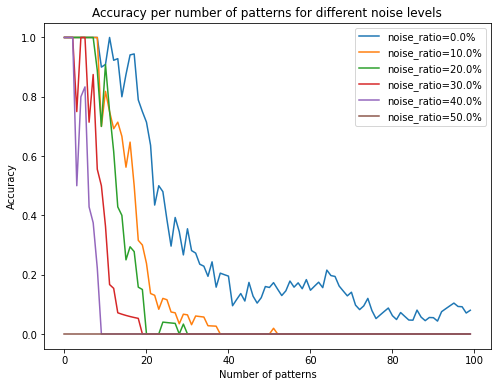

In [42]:
fig = plt.figure(figsize=(8,6))
    
for noise_ratio, accuracies in accuracies_per_noise_ratio.items():
    plt.plot(accuracies, label=f"noise_ratio={float(noise_ratio)*100}%")
    
plt.xlabel('Number of patterns')
plt.ylabel('Accuracy')
plt.title('Accuracy per number of patterns for different noise levels')
plt.legend()
plt.show()

Q: What happens if convergence to the pattern from a noisy version (a few flipped units) is used? What does the different behavior for large number of patterns mean?

Answer: ??

The self-connections are always positive and quite strong; they always support units to remain at their current state. If you remove them and compare the curves from pure and noisy patterns for large number of patterns you will see that the difference goes away. In general it is a good idea to remove self-connections, even though it seems that this step lowers the memory performance. In fact, self-connections promote the formation of spurious patterns and have negative effect on noise removal capabilities.

n_pattern=1, accuracy=1.0
n_pattern=2, accuracy=1.0
n_pattern=3, accuracy=1.0
n_pattern=4, accuracy=1.0
n_pattern=5, accuracy=1.0
n_pattern=6, accuracy=1.0
n_pattern=7, accuracy=1.0
n_pattern=8, accuracy=1.0
n_pattern=9, accuracy=1.0
n_pattern=10, accuracy=0.9
n_pattern=11, accuracy=0.9090909090909091
n_pattern=12, accuracy=0.9166666666666666
n_pattern=13, accuracy=0.7692307692307693
n_pattern=14, accuracy=0.7142857142857143
n_pattern=15, accuracy=0.7333333333333333
n_pattern=16, accuracy=0.6875
n_pattern=17, accuracy=0.5294117647058824
n_pattern=18, accuracy=0.3888888888888889
n_pattern=19, accuracy=0.5263157894736842
n_pattern=20, accuracy=0.35
n_pattern=21, accuracy=0.14285714285714285
n_pattern=22, accuracy=0.3181818181818182
n_pattern=23, accuracy=0.21739130434782608
n_pattern=24, accuracy=0.20833333333333334
n_pattern=25, accuracy=0.08
n_pattern=26, accuracy=0.15384615384615385
n_pattern=27, accuracy=0.07407407407407407
n_pattern=28, accuracy=0.0
n_pattern=29, accuracy=0.06896551

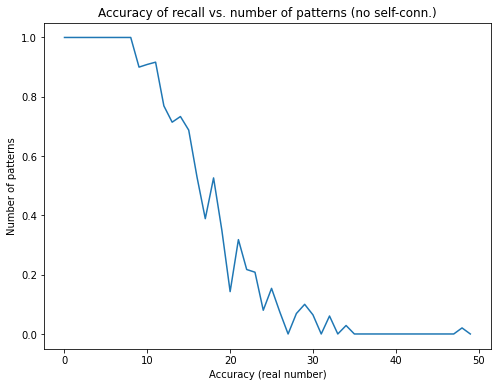

In [43]:
# This cell takes around 3-4 mins to run on Intel i7 CPU

self_connections = False
n_patterns = 50
ndim = 100
ns_patterns = np.arange(1, n_patterns+1)
accuracies_all = []

for n_pattern in ns_patterns:
    
    patterns_random = get_random_patterns(n=n_pattern, ndim=ndim)
    hn = HopfieldNetwork()
    hn.init_weights(patterns_random, self_connections=self_connections, norm=False)
    accuracies = []
    
    for pattern in patterns_random:
        
        patternr, it, energies = hn.recall_until_convergence(pattern, with_energy=False, if_sequential=False, 
                                                  exit=10000)
        accuracies.append(np.all(pattern == patternr))
    
    accuracy = np.sum(np.array(accuracies)) / patterns_random.shape[0]
    accuracies_all.append(accuracy)
    
    print(f"n_pattern={n_pattern}, accuracy={accuracy}")

fig = plt.figure(figsize=(8,6))
plt.plot(accuracies_all)
plt.title("Accuracy of recall vs. number of patterns (no self-conn.)")
plt.xlabel("Accuracy (real number)")
plt.ylabel("Number of patterns")
plt.show()

noise_ratio=0.0, n_pattern=1, accuracy=1.0
noise_ratio=0.0, n_pattern=2, accuracy=1.0
noise_ratio=0.0, n_pattern=3, accuracy=1.0
noise_ratio=0.0, n_pattern=4, accuracy=1.0
noise_ratio=0.0, n_pattern=5, accuracy=1.0
noise_ratio=0.0, n_pattern=6, accuracy=1.0
noise_ratio=0.0, n_pattern=7, accuracy=1.0
noise_ratio=0.0, n_pattern=8, accuracy=1.0
noise_ratio=0.0, n_pattern=9, accuracy=1.0
noise_ratio=0.0, n_pattern=10, accuracy=0.8
noise_ratio=0.0, n_pattern=11, accuracy=0.7272727272727273
noise_ratio=0.0, n_pattern=12, accuracy=0.6666666666666666
noise_ratio=0.0, n_pattern=13, accuracy=0.6923076923076923
noise_ratio=0.0, n_pattern=14, accuracy=0.6428571428571429
noise_ratio=0.0, n_pattern=15, accuracy=0.5333333333333333
noise_ratio=0.0, n_pattern=16, accuracy=0.5625
noise_ratio=0.0, n_pattern=17, accuracy=0.5294117647058824
noise_ratio=0.0, n_pattern=18, accuracy=0.3333333333333333
noise_ratio=0.0, n_pattern=19, accuracy=0.42105263157894735
noise_ratio=0.0, n_pattern=20, accuracy=0.3
noise

noise_ratio=0.3, n_pattern=24, accuracy=0.0
noise_ratio=0.3, n_pattern=25, accuracy=0.0
noise_ratio=0.3, n_pattern=26, accuracy=0.0
noise_ratio=0.3, n_pattern=27, accuracy=0.0
noise_ratio=0.3, n_pattern=28, accuracy=0.0
noise_ratio=0.3, n_pattern=29, accuracy=0.0
noise_ratio=0.3, n_pattern=30, accuracy=0.0
noise_ratio=0.3, n_pattern=31, accuracy=0.0
noise_ratio=0.3, n_pattern=32, accuracy=0.0
noise_ratio=0.3, n_pattern=33, accuracy=0.0
noise_ratio=0.3, n_pattern=34, accuracy=0.0
noise_ratio=0.3, n_pattern=35, accuracy=0.0
noise_ratio=0.3, n_pattern=36, accuracy=0.0
noise_ratio=0.3, n_pattern=37, accuracy=0.0
noise_ratio=0.3, n_pattern=38, accuracy=0.0
noise_ratio=0.3, n_pattern=39, accuracy=0.0
noise_ratio=0.3, n_pattern=40, accuracy=0.0
noise_ratio=0.3, n_pattern=41, accuracy=0.0
noise_ratio=0.3, n_pattern=42, accuracy=0.0
noise_ratio=0.3, n_pattern=43, accuracy=0.0
noise_ratio=0.3, n_pattern=44, accuracy=0.0
noise_ratio=0.3, n_pattern=45, accuracy=0.0
noise_ratio=0.3, n_pattern=46, a

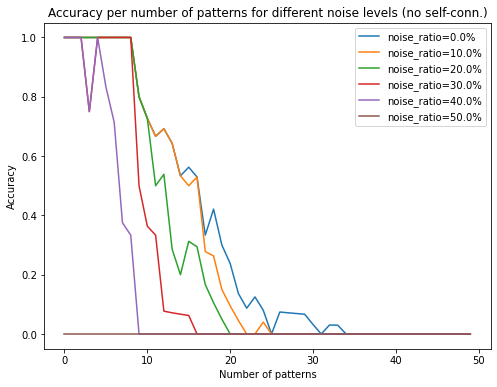

In [44]:
# This cell takes around 3-4 mins to run on Intel i7 CPU

self_connections = False
n_patterns = 50
ndim = 100
ns_patterns = np.arange(1, n_patterns+1)

accuracies_per_noise_ratio = {}

noise_ratios = np.arange(0,6) / 10

for noise_ratio in noise_ratios:
    accuracies_all = []
    for n_pattern in ns_patterns:

        patterns_random = get_random_patterns(n=n_pattern, ndim=ndim)
        hn = HopfieldNetwork()
        hn.init_weights(patterns_random, self_connections=self_connections, norm=False)
        accuracies = []
        for pattern in patterns_random:
            pattern_noisy = add_noise_via_flip(pattern, noise_ratio)
            patternr, it, energies = hn.recall_until_convergence(pattern_noisy, 
                                                                 with_energy=False, if_sequential=False, 
                                                                 exit=10000)

            accuracies.append(np.all(pattern == patternr))

        accuracy = np.sum(np.array(accuracies)) / patterns_random.shape[0]
        accuracies_all.append(accuracy)

        print(f"noise_ratio={noise_ratio}, n_pattern={n_pattern}, accuracy={accuracy}")
    
    accuracies_per_noise_ratio[str(noise_ratio)] = accuracies_all
    
fig = plt.figure(figsize=(8,6))
    
for noise_ratio, accuracies in accuracies_per_noise_ratio.items():
    plt.plot(accuracies, label=f"noise_ratio={float(noise_ratio)*100}%")
    
plt.xlabel('Number of patterns')
plt.ylabel('Accuracy')
plt.title('Accuracy per number of patterns for different noise levels (no self-conn.)')
plt.legend()
plt.show()

Q: What is the maximum number of retrievable patterns for this network?

Answer: ??

noise_ratio=0.0, n_pattern=1, accuracy=1.0
noise_ratio=0.0, n_pattern=2, accuracy=1.0
noise_ratio=0.0, n_pattern=3, accuracy=1.0
noise_ratio=0.0, n_pattern=4, accuracy=1.0
noise_ratio=0.0, n_pattern=5, accuracy=1.0
noise_ratio=0.0, n_pattern=6, accuracy=0.8333333333333334
noise_ratio=0.0, n_pattern=7, accuracy=0.5714285714285714
noise_ratio=0.0, n_pattern=8, accuracy=0.5
noise_ratio=0.0, n_pattern=9, accuracy=0.4444444444444444
noise_ratio=0.0, n_pattern=10, accuracy=0.1
noise_ratio=0.0, n_pattern=11, accuracy=0.18181818181818182
noise_ratio=0.0, n_pattern=12, accuracy=0.16666666666666666
noise_ratio=0.0, n_pattern=13, accuracy=0.07692307692307693
noise_ratio=0.0, n_pattern=14, accuracy=0.07142857142857142
noise_ratio=0.0, n_pattern=15, accuracy=0.06666666666666667
noise_ratio=0.0, n_pattern=16, accuracy=0.0625
noise_ratio=0.0, n_pattern=17, accuracy=0.058823529411764705
noise_ratio=0.0, n_pattern=18, accuracy=0.05555555555555555
noise_ratio=0.0, n_pattern=19, accuracy=0.0
noise_ratio=

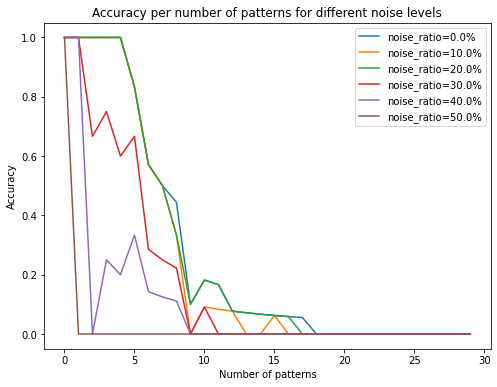

In [45]:
bias = 0.5
n_patterns = 30
ndim = 100
ns_patterns = np.arange(1, n_patterns+1)

accuracies_per_noise_ratio = {}

noise_ratios = np.arange(0,6) / 10

for noise_ratio in noise_ratios:
    accuracies_all = []
    for n_pattern in ns_patterns:

        patterns_random = get_random_patterns(n=n_pattern, ndim=ndim, bias=bias)
        hn = HopfieldNetwork()
        hn.init_weights(patterns_random, self_connections=True, norm=False)
        accuracies = []
        for pattern in patterns_random:
            pattern_noisy = add_noise_via_flip(pattern, noise_ratio)
            patternr, it, energies = hn.recall_until_convergence(pattern_noisy, 
                                                                 with_energy=False, if_sequential=False, 
                                                                 exit=10000)

            accuracies.append(np.all(pattern == patternr))

        accuracy = np.sum(np.array(accuracies)) / patterns_random.shape[0]
        accuracies_all.append(accuracy)

        print(f"noise_ratio={noise_ratio}, n_pattern={n_pattern}, accuracy={accuracy}")
    
    accuracies_per_noise_ratio[str(noise_ratio)] = accuracies_all

fig = plt.figure(figsize=(8,6))
    
for noise_ratio, accuracies in accuracies_per_noise_ratio.items():
    plt.plot(accuracies, label=f"noise_ratio={float(noise_ratio)*100}%")
    
plt.xlabel('Number of patterns')
plt.ylabel('Accuracy')
plt.title('Accuracy per number of patterns for different noise levels')
plt.legend()
plt.show()

Q: What happens if you bias the patterns, e.g. use sign(0.5+randn(300,100)) or something similar to make them contain more +1? How does this relate to the capacity results of the picture patterns?

Answer: ??

## 3.6 Sparse Patterns

The reduction in capacity because of bias is troublesome, since real data usually is not evenly balanced.

In [46]:
def get_random_patterns_sparse(n, ndim, activity=0.7):
    patterns = np.zeros((n, ndim))
    n_active = int(activity * patterns.shape[1])
    
    for pattern in patterns:
        indices = np.arange(pattern.shape[0])
        mask = np.random.choice(indices, n_active, replace=False)
        pattern[mask] = 1.0
    
    average_activity = np.sum(patterns) * (patterns.shape[1] * patterns.shape[0])**(-1)
    print(f"mean activity level: {average_activity * 100:.2f}%")
    
    return patterns

In [47]:
# Tessting

n_pattern = 3
ndim = 100
activity=0.1

patterns_random_sparse = get_random_patterns_sparse(n=n_pattern, ndim=ndim, activity=activity)
patterns_random_sparse

mean activity level: 10.00%


array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

[[ 0.    0.03  0.03 ... -0.07 -0.07  0.03]
 [ 0.03  0.    0.03 ... -0.07 -0.07  0.03]
 [ 0.03  0.03  0.   ... -0.07 -0.07  0.03]
 ...
 [-0.07 -0.07 -0.07 ...  0.    0.83 -0.07]
 [-0.07 -0.07 -0.07 ...  0.83  0.   -0.07]
 [ 0.03  0.03  0.03 ... -0.07 -0.07  0.  ]]
True


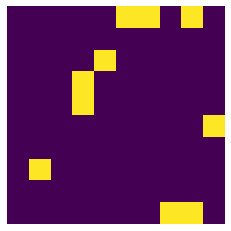

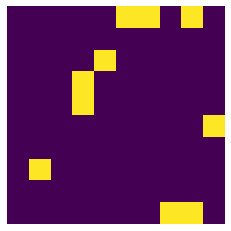

In [48]:
# Testing

idx = 1
sparse = True
bias = 2
hn = HopfieldNetwork(sparse=sparse)
hn.init_weights(patterns_random_sparse, self_connections=False, norm=False, bias=bias)
print(hn.weights)
patternr, it, energies = hn.recall_until_convergence(patterns_random_sparse[idx], 
                                                     with_energy=False, if_sequential=False, 
                                                     exit=10000)
print(np.all(patternr == patterns_random_sparse[idx]))

plt.imshow(patterns_random_sparse[idx].reshape(10,10))
plt.axis("off")
plt.show()

plt.imshow(patternr.reshape(10,10))
plt.axis("off")
plt.show()

mean activity level: 10.00%
bias=-2.0, n_pattern=1, accuracy=0.0
mean activity level: 10.00%
bias=-2.0, n_pattern=2, accuracy=0.0
mean activity level: 10.00%
bias=-2.0, n_pattern=3, accuracy=0.0
mean activity level: 10.00%
bias=-2.0, n_pattern=4, accuracy=0.0
mean activity level: 10.00%
bias=-2.0, n_pattern=5, accuracy=0.0
mean activity level: 10.00%
bias=-2.0, n_pattern=6, accuracy=0.0
mean activity level: 10.00%
bias=-2.0, n_pattern=7, accuracy=0.0
mean activity level: 10.00%
bias=-2.0, n_pattern=8, accuracy=0.0
mean activity level: 10.00%
bias=-2.0, n_pattern=9, accuracy=0.0
mean activity level: 10.00%
bias=-2.0, n_pattern=10, accuracy=0.0
mean activity level: 10.00%
bias=-2.0, n_pattern=11, accuracy=0.0
mean activity level: 10.00%
bias=-2.0, n_pattern=12, accuracy=0.0
mean activity level: 10.00%
bias=-2.0, n_pattern=13, accuracy=0.0
mean activity level: 10.00%
bias=-2.0, n_pattern=14, accuracy=0.0
mean activity level: 10.00%
bias=-2.0, n_pattern=15, accuracy=0.0
mean activity level

mean activity level: 10.00%
bias=-0.5, n_pattern=30, accuracy=0.0
mean activity level: 10.00%
bias=-0.5, n_pattern=31, accuracy=0.0
mean activity level: 10.00%
bias=-0.5, n_pattern=32, accuracy=0.0
mean activity level: 10.00%
bias=-0.5, n_pattern=33, accuracy=0.0
mean activity level: 10.00%
bias=-0.5, n_pattern=34, accuracy=0.0
mean activity level: 10.00%
bias=-0.5, n_pattern=35, accuracy=0.0
mean activity level: 10.00%
bias=0.0, n_pattern=1, accuracy=1.0
mean activity level: 10.00%
bias=0.0, n_pattern=2, accuracy=1.0
mean activity level: 10.00%
bias=0.0, n_pattern=3, accuracy=1.0
mean activity level: 10.00%
bias=0.0, n_pattern=4, accuracy=0.25
mean activity level: 10.00%
bias=0.0, n_pattern=5, accuracy=0.4
mean activity level: 10.00%
bias=0.0, n_pattern=6, accuracy=0.6666666666666666
mean activity level: 10.00%
bias=0.0, n_pattern=7, accuracy=0.42857142857142855
mean activity level: 10.00%
bias=0.0, n_pattern=8, accuracy=0.125
mean activity level: 10.00%
bias=0.0, n_pattern=9, accurac

mean activity level: 10.00%
bias=1.5, n_pattern=29, accuracy=0.13793103448275862
mean activity level: 10.00%
bias=1.5, n_pattern=30, accuracy=0.1
mean activity level: 10.00%
bias=1.5, n_pattern=31, accuracy=0.0967741935483871
mean activity level: 10.00%
bias=1.5, n_pattern=32, accuracy=0.0625
mean activity level: 10.00%
bias=1.5, n_pattern=33, accuracy=0.06060606060606061
mean activity level: 10.00%
bias=1.5, n_pattern=34, accuracy=0.058823529411764705
mean activity level: 10.00%
bias=1.5, n_pattern=35, accuracy=0.05714285714285714
mean activity level: 10.00%
bias=2.0, n_pattern=1, accuracy=1.0
mean activity level: 10.00%
bias=2.0, n_pattern=2, accuracy=1.0
mean activity level: 10.00%
bias=2.0, n_pattern=3, accuracy=1.0
mean activity level: 10.00%
bias=2.0, n_pattern=4, accuracy=1.0
mean activity level: 10.00%
bias=2.0, n_pattern=5, accuracy=1.0
mean activity level: 10.00%
bias=2.0, n_pattern=6, accuracy=1.0
mean activity level: 10.00%
bias=2.0, n_pattern=7, accuracy=1.0
mean activity 

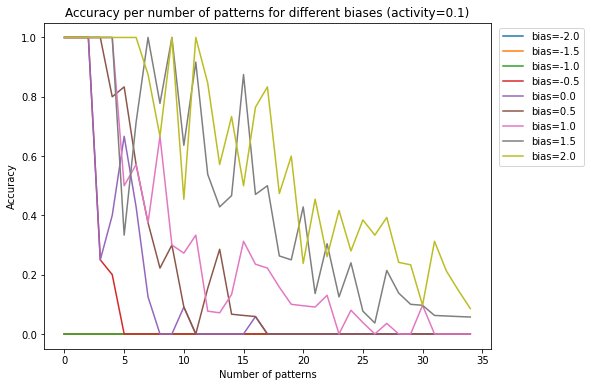

In [49]:
n_patterns = 35
ndim = 100
activity = 0.1
sparse = True

ns_patterns = np.arange(1, n_patterns+1)

accuracies_per_biases = {}

biases = np.arange(-20,22,5) / 10

for bias in biases:
    accuracies_all = []
    for n_pattern in ns_patterns:

        patterns_random = get_random_patterns_sparse(n=n_pattern, ndim=ndim, activity=activity)
        hn = HopfieldNetwork(sparse=sparse)
        hn.init_weights(patterns_random, self_connections=True, norm=False, bias=bias)
        accuracies = []
        for pattern in patterns_random:
            #pattern_noisy = add_noise_via_flip(pattern, noise_ratio)
            patternr, it, energies = hn.recall_until_convergence(pattern, 
                                                                 with_energy=False, if_sequential=False, 
                                                                 exit=10000)

            accuracies.append(np.all(pattern == patternr))

        accuracy = np.sum(np.array(accuracies)) / patterns_random.shape[0]
        accuracies_all.append(accuracy)

        print(f"bias={bias}, n_pattern={n_pattern}, accuracy={accuracy}")
    
    accuracies_per_biases[str(bias)] = accuracies_all
    
fig = plt.figure(figsize=(8,6))
    
for bias, accuracies in accuracies_per_biases.items():
    plt.plot(accuracies, label=f"bias={bias}")
    
plt.xlabel('Number of patterns')
plt.ylabel('Accuracy')
plt.title(f'Accuracy per number of patterns for different biases (activity={activity})')
plt.legend(bbox_to_anchor=(1.22, 1), loc="upper right")
plt.show()

mean activity level: 5.00%
bias=-2.0, n_pattern=1, accuracy=0.0
mean activity level: 5.00%
bias=-2.0, n_pattern=2, accuracy=0.0
mean activity level: 5.00%
bias=-2.0, n_pattern=3, accuracy=0.0
mean activity level: 5.00%
bias=-2.0, n_pattern=4, accuracy=0.0
mean activity level: 5.00%
bias=-2.0, n_pattern=5, accuracy=0.0
mean activity level: 5.00%
bias=-2.0, n_pattern=6, accuracy=0.0
mean activity level: 5.00%
bias=-2.0, n_pattern=7, accuracy=0.0
mean activity level: 5.00%
bias=-2.0, n_pattern=8, accuracy=0.0
mean activity level: 5.00%
bias=-2.0, n_pattern=9, accuracy=0.0
mean activity level: 5.00%
bias=-2.0, n_pattern=10, accuracy=0.0
mean activity level: 5.00%
bias=-2.0, n_pattern=11, accuracy=0.0
mean activity level: 5.00%
bias=-2.0, n_pattern=12, accuracy=0.0
mean activity level: 5.00%
bias=-2.0, n_pattern=13, accuracy=0.0
mean activity level: 5.00%
bias=-2.0, n_pattern=14, accuracy=0.0
mean activity level: 5.00%
bias=-2.0, n_pattern=15, accuracy=0.0
mean activity level: 5.00%
bias=-2

bias=-1.0, n_pattern=36, accuracy=0.0
mean activity level: 5.00%
bias=-1.0, n_pattern=37, accuracy=0.0
mean activity level: 5.00%
bias=-1.0, n_pattern=38, accuracy=0.0
mean activity level: 5.00%
bias=-1.0, n_pattern=39, accuracy=0.0
mean activity level: 5.00%
bias=-1.0, n_pattern=40, accuracy=0.0
mean activity level: 5.00%
bias=-1.0, n_pattern=41, accuracy=0.0
mean activity level: 5.00%
bias=-1.0, n_pattern=42, accuracy=0.0
mean activity level: 5.00%
bias=-1.0, n_pattern=43, accuracy=0.0
mean activity level: 5.00%
bias=-1.0, n_pattern=44, accuracy=0.0
mean activity level: 5.00%
bias=-1.0, n_pattern=45, accuracy=0.0
mean activity level: 5.00%
bias=-1.0, n_pattern=46, accuracy=0.0
mean activity level: 5.00%
bias=-1.0, n_pattern=47, accuracy=0.0
mean activity level: 5.00%
bias=-1.0, n_pattern=48, accuracy=0.0
mean activity level: 5.00%
bias=-1.0, n_pattern=49, accuracy=0.0
mean activity level: 5.00%
bias=-1.0, n_pattern=50, accuracy=0.0
mean activity level: 5.00%
bias=-1.0, n_pattern=51, 

bias=0.0, n_pattern=59, accuracy=0.0
mean activity level: 5.00%
bias=0.0, n_pattern=60, accuracy=0.0
mean activity level: 5.00%
bias=0.5, n_pattern=1, accuracy=1.0
mean activity level: 5.00%
bias=0.5, n_pattern=2, accuracy=1.0
mean activity level: 5.00%
bias=0.5, n_pattern=3, accuracy=1.0
mean activity level: 5.00%
bias=0.5, n_pattern=4, accuracy=0.5
mean activity level: 5.00%
bias=0.5, n_pattern=5, accuracy=0.6
mean activity level: 5.00%
bias=0.5, n_pattern=6, accuracy=0.16666666666666666
mean activity level: 5.00%
bias=0.5, n_pattern=7, accuracy=0.42857142857142855
mean activity level: 5.00%
bias=0.5, n_pattern=8, accuracy=0.375
mean activity level: 5.00%
bias=0.5, n_pattern=9, accuracy=0.1111111111111111
mean activity level: 5.00%
bias=0.5, n_pattern=10, accuracy=0.2
mean activity level: 5.00%
bias=0.5, n_pattern=11, accuracy=0.18181818181818182
mean activity level: 5.00%
bias=0.5, n_pattern=12, accuracy=0.16666666666666666
mean activity level: 5.00%
bias=0.5, n_pattern=13, accuracy

bias=1.0, n_pattern=58, accuracy=0.0
mean activity level: 5.00%
bias=1.0, n_pattern=59, accuracy=0.01694915254237288
mean activity level: 5.00%
bias=1.0, n_pattern=60, accuracy=0.016666666666666666
mean activity level: 5.00%
bias=1.5, n_pattern=1, accuracy=1.0
mean activity level: 5.00%
bias=1.5, n_pattern=2, accuracy=1.0
mean activity level: 5.00%
bias=1.5, n_pattern=3, accuracy=1.0
mean activity level: 5.00%
bias=1.5, n_pattern=4, accuracy=1.0
mean activity level: 5.00%
bias=1.5, n_pattern=5, accuracy=1.0
mean activity level: 5.00%
bias=1.5, n_pattern=6, accuracy=1.0
mean activity level: 5.00%
bias=1.5, n_pattern=7, accuracy=1.0
mean activity level: 5.00%
bias=1.5, n_pattern=8, accuracy=1.0
mean activity level: 5.00%
bias=1.5, n_pattern=9, accuracy=1.0
mean activity level: 5.00%
bias=1.5, n_pattern=10, accuracy=1.0
mean activity level: 5.00%
bias=1.5, n_pattern=11, accuracy=1.0
mean activity level: 5.00%
bias=1.5, n_pattern=12, accuracy=0.8333333333333334
mean activity level: 5.00%
b

bias=2.0, n_pattern=58, accuracy=0.3448275862068966
mean activity level: 5.00%
bias=2.0, n_pattern=59, accuracy=0.5932203389830508
mean activity level: 5.00%
bias=2.0, n_pattern=60, accuracy=0.7166666666666667


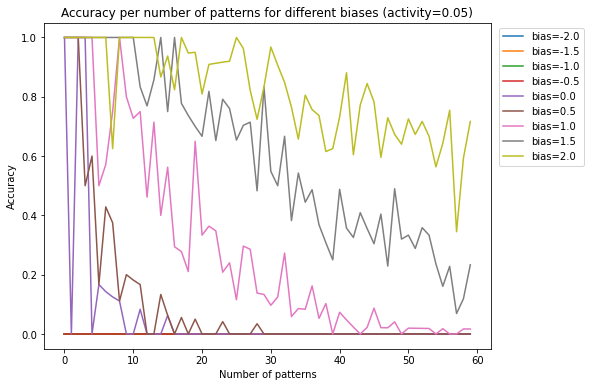

In [50]:
n_patterns = 60
ndim = 100
activity = 0.05
sparse = True

ns_patterns = np.arange(1, n_patterns+1)

accuracies_per_biases = {}

biases = np.arange(-20,22,5) / 10

for bias in biases:
    accuracies_all = []
    for n_pattern in ns_patterns:

        patterns_random = get_random_patterns_sparse(n=n_pattern, ndim=ndim, activity=activity)
        hn = HopfieldNetwork(sparse=sparse)
        hn.init_weights(patterns_random, self_connections=True, norm=False, bias=bias)
        accuracies = []
        for pattern in patterns_random:
            #pattern_noisy = add_noise_via_flip(pattern, noise_ratio)
            patternr, it, energies = hn.recall_until_convergence(pattern, 
                                                                 with_energy=False, if_sequential=False, 
                                                                 exit=10000)

            accuracies.append(np.all(pattern == patternr))

        accuracy = np.sum(np.array(accuracies)) / patterns_random.shape[0]
        accuracies_all.append(accuracy)

        print(f"bias={bias}, n_pattern={n_pattern}, accuracy={accuracy}")
    
    accuracies_per_biases[str(bias)] = accuracies_all
    
fig = plt.figure(figsize=(8,6))
    
for bias, accuracies in accuracies_per_biases.items():
    plt.plot(accuracies, label=f"bias={bias}")
    
plt.xlabel('Number of patterns')
plt.ylabel('Accuracy')
plt.title(f'Accuracy per number of patterns for different biases (activity={activity})')
plt.legend(bbox_to_anchor=(1.22, 1), loc="upper right")
plt.show()

mean activity level: 1.00%
bias=-2.0, n_pattern=1, accuracy=0.0
mean activity level: 1.00%
bias=-2.0, n_pattern=2, accuracy=0.0
mean activity level: 1.00%
bias=-2.0, n_pattern=3, accuracy=0.0
mean activity level: 1.00%
bias=-2.0, n_pattern=4, accuracy=0.0
mean activity level: 1.00%
bias=-2.0, n_pattern=5, accuracy=0.0
mean activity level: 1.00%
bias=-2.0, n_pattern=6, accuracy=0.0
mean activity level: 1.00%
bias=-2.0, n_pattern=7, accuracy=0.0
mean activity level: 1.00%
bias=-2.0, n_pattern=8, accuracy=0.0
mean activity level: 1.00%
bias=-2.0, n_pattern=9, accuracy=0.0
mean activity level: 1.00%
bias=-2.0, n_pattern=10, accuracy=0.0
mean activity level: 1.00%
bias=-2.0, n_pattern=11, accuracy=0.0
mean activity level: 1.00%
bias=-2.0, n_pattern=12, accuracy=0.0
mean activity level: 1.00%
bias=-2.0, n_pattern=13, accuracy=0.0
mean activity level: 1.00%
bias=-2.0, n_pattern=14, accuracy=0.0
mean activity level: 1.00%
bias=-2.0, n_pattern=15, accuracy=0.0
mean activity level: 1.00%
bias=-2

mean activity level: 1.00%
bias=-1.5, n_pattern=41, accuracy=0.0
mean activity level: 1.00%
bias=-1.5, n_pattern=42, accuracy=0.0
mean activity level: 1.00%
bias=-1.5, n_pattern=43, accuracy=0.0
mean activity level: 1.00%
bias=-1.5, n_pattern=44, accuracy=0.0
mean activity level: 1.00%
bias=-1.5, n_pattern=45, accuracy=0.0
mean activity level: 1.00%
bias=-1.5, n_pattern=46, accuracy=0.0
mean activity level: 1.00%
bias=-1.5, n_pattern=47, accuracy=0.0
mean activity level: 1.00%
bias=-1.5, n_pattern=48, accuracy=0.0
mean activity level: 1.00%
bias=-1.5, n_pattern=49, accuracy=0.0
mean activity level: 1.00%
bias=-1.5, n_pattern=50, accuracy=0.0
mean activity level: 1.00%
bias=-1.5, n_pattern=51, accuracy=0.0
mean activity level: 1.00%
bias=-1.5, n_pattern=52, accuracy=0.0
mean activity level: 1.00%
bias=-1.5, n_pattern=53, accuracy=0.0
mean activity level: 1.00%
bias=-1.5, n_pattern=54, accuracy=0.0
mean activity level: 1.00%
bias=-1.5, n_pattern=55, accuracy=0.0
mean activity level: 1.00

bias=-1.0, n_pattern=93, accuracy=0.0
mean activity level: 1.00%
bias=-1.0, n_pattern=94, accuracy=0.0
mean activity level: 1.00%
bias=-1.0, n_pattern=95, accuracy=0.0
mean activity level: 1.00%
bias=-1.0, n_pattern=96, accuracy=0.0
mean activity level: 1.00%
bias=-1.0, n_pattern=97, accuracy=0.0
mean activity level: 1.00%
bias=-1.0, n_pattern=98, accuracy=0.0
mean activity level: 1.00%
bias=-1.0, n_pattern=99, accuracy=0.0
mean activity level: 1.00%
bias=-1.0, n_pattern=100, accuracy=0.0
mean activity level: 1.00%
bias=-0.5, n_pattern=1, accuracy=0.0
mean activity level: 1.00%
bias=-0.5, n_pattern=2, accuracy=0.0
mean activity level: 1.00%
bias=-0.5, n_pattern=3, accuracy=0.0
mean activity level: 1.00%
bias=-0.5, n_pattern=4, accuracy=0.0
mean activity level: 1.00%
bias=-0.5, n_pattern=5, accuracy=0.0
mean activity level: 1.00%
bias=-0.5, n_pattern=6, accuracy=0.0
mean activity level: 1.00%
bias=-0.5, n_pattern=7, accuracy=0.0
mean activity level: 1.00%
bias=-0.5, n_pattern=8, accurac

bias=0.0, n_pattern=25, accuracy=1.0
mean activity level: 1.00%
bias=0.0, n_pattern=26, accuracy=1.0
mean activity level: 1.00%
bias=0.0, n_pattern=27, accuracy=1.0
mean activity level: 1.00%
bias=0.0, n_pattern=28, accuracy=1.0
mean activity level: 1.00%
bias=0.0, n_pattern=29, accuracy=1.0
mean activity level: 1.00%
bias=0.0, n_pattern=30, accuracy=1.0
mean activity level: 1.00%
bias=0.0, n_pattern=31, accuracy=1.0
mean activity level: 1.00%
bias=0.0, n_pattern=32, accuracy=1.0
mean activity level: 1.00%
bias=0.0, n_pattern=33, accuracy=1.0
mean activity level: 1.00%
bias=0.0, n_pattern=34, accuracy=1.0
mean activity level: 1.00%
bias=0.0, n_pattern=35, accuracy=1.0
mean activity level: 1.00%
bias=0.0, n_pattern=36, accuracy=1.0
mean activity level: 1.00%
bias=0.0, n_pattern=37, accuracy=1.0
mean activity level: 1.00%
bias=0.0, n_pattern=38, accuracy=1.0
mean activity level: 1.00%
bias=0.0, n_pattern=39, accuracy=1.0
mean activity level: 1.00%
bias=0.0, n_pattern=40, accuracy=1.0
mea

bias=0.5, n_pattern=78, accuracy=1.0
mean activity level: 1.00%
bias=0.5, n_pattern=79, accuracy=1.0
mean activity level: 1.00%
bias=0.5, n_pattern=80, accuracy=1.0
mean activity level: 1.00%
bias=0.5, n_pattern=81, accuracy=1.0
mean activity level: 1.00%
bias=0.5, n_pattern=82, accuracy=1.0
mean activity level: 1.00%
bias=0.5, n_pattern=83, accuracy=1.0
mean activity level: 1.00%
bias=0.5, n_pattern=84, accuracy=1.0
mean activity level: 1.00%
bias=0.5, n_pattern=85, accuracy=1.0
mean activity level: 1.00%
bias=0.5, n_pattern=86, accuracy=1.0
mean activity level: 1.00%
bias=0.5, n_pattern=87, accuracy=1.0
mean activity level: 1.00%
bias=0.5, n_pattern=88, accuracy=1.0
mean activity level: 1.00%
bias=0.5, n_pattern=89, accuracy=1.0
mean activity level: 1.00%
bias=0.5, n_pattern=90, accuracy=1.0
mean activity level: 1.00%
bias=0.5, n_pattern=91, accuracy=1.0
mean activity level: 1.00%
bias=0.5, n_pattern=92, accuracy=1.0
mean activity level: 1.00%
bias=0.5, n_pattern=93, accuracy=1.0
mea

bias=1.0, n_pattern=98, accuracy=0.6428571428571429
mean activity level: 1.00%
bias=1.0, n_pattern=99, accuracy=0.5656565656565656
mean activity level: 1.00%
bias=1.0, n_pattern=100, accuracy=0.6
mean activity level: 1.00%
bias=1.5, n_pattern=1, accuracy=0.0
mean activity level: 1.00%
bias=1.5, n_pattern=2, accuracy=0.0
mean activity level: 1.00%
bias=1.5, n_pattern=3, accuracy=0.0
mean activity level: 1.00%
bias=1.5, n_pattern=4, accuracy=0.0
mean activity level: 1.00%
bias=1.5, n_pattern=5, accuracy=0.0
mean activity level: 1.00%
bias=1.5, n_pattern=6, accuracy=0.0
mean activity level: 1.00%
bias=1.5, n_pattern=7, accuracy=0.0
mean activity level: 1.00%
bias=1.5, n_pattern=8, accuracy=0.0
mean activity level: 1.00%
bias=1.5, n_pattern=9, accuracy=0.2222222222222222
mean activity level: 1.00%
bias=1.5, n_pattern=10, accuracy=0.4
mean activity level: 1.00%
bias=1.5, n_pattern=11, accuracy=0.18181818181818182
mean activity level: 1.00%
bias=1.5, n_pattern=12, accuracy=0.0
mean activity 

bias=2.0, n_pattern=45, accuracy=0.06666666666666667
mean activity level: 1.00%
bias=2.0, n_pattern=46, accuracy=0.1956521739130435
mean activity level: 1.00%
bias=2.0, n_pattern=47, accuracy=0.06382978723404255
mean activity level: 1.00%
bias=2.0, n_pattern=48, accuracy=0.0
mean activity level: 1.00%
bias=2.0, n_pattern=49, accuracy=0.12244897959183673
mean activity level: 1.00%
bias=2.0, n_pattern=50, accuracy=0.06
mean activity level: 1.00%
bias=2.0, n_pattern=51, accuracy=0.058823529411764705
mean activity level: 1.00%
bias=2.0, n_pattern=52, accuracy=0.17307692307692307
mean activity level: 1.00%
bias=2.0, n_pattern=53, accuracy=0.05660377358490566
mean activity level: 1.00%
bias=2.0, n_pattern=54, accuracy=0.16666666666666666
mean activity level: 1.00%
bias=2.0, n_pattern=55, accuracy=0.05454545454545454
mean activity level: 1.00%
bias=2.0, n_pattern=56, accuracy=0.05357142857142857
mean activity level: 1.00%
bias=2.0, n_pattern=57, accuracy=0.12280701754385964
mean activity leve

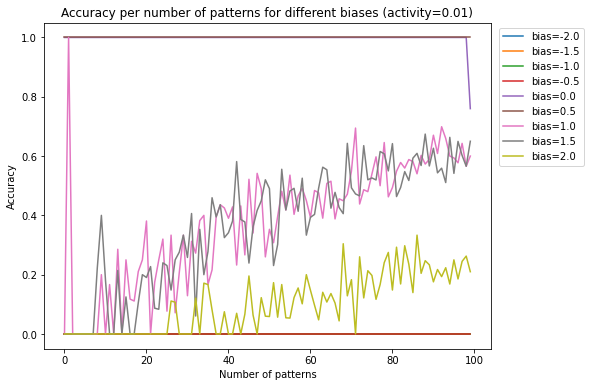

In [51]:
n_patterns = 100
ndim = 100
activity = 0.01
sparse = True

ns_patterns = np.arange(1, n_patterns+1)

accuracies_per_biases = {}

biases = np.arange(-20,22,5) / 10

for bias in biases:
    accuracies_all = []
    for n_pattern in ns_patterns:

        patterns_random = get_random_patterns_sparse(n=n_pattern, ndim=ndim, activity=activity)
        hn = HopfieldNetwork(sparse=sparse)
        hn.init_weights(patterns_random, self_connections=True, norm=False, bias=bias)
        accuracies = []
        for pattern in patterns_random:
            #pattern_noisy = add_noise_via_flip(pattern, noise_ratio)
            patternr, it, energies = hn.recall_until_convergence(pattern, 
                                                                 with_energy=False, if_sequential=False, 
                                                                 exit=10000)

            accuracies.append(np.all(pattern == patternr))

        accuracy = np.sum(np.array(accuracies)) / patterns_random.shape[0]
        accuracies_all.append(accuracy)

        print(f"bias={bias}, n_pattern={n_pattern}, accuracy={accuracy}")
    
    accuracies_per_biases[str(bias)] = accuracies_all
    
fig = plt.figure(figsize=(8,6))
    
for bias, accuracies in accuracies_per_biases.items():
    plt.plot(accuracies, label=f"bias={bias}")
    
plt.xlabel('Number of patterns')
plt.ylabel('Accuracy')
plt.title(f'Accuracy per number of patterns for different biases (activity={activity})')
plt.legend(bbox_to_anchor=(1.22, 1), loc="upper right")
plt.show()